# 1. Preparation

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Setting option to display maximum of 25 columns from dataframe
pd.set_option('display.max_columns', 25)

In [3]:
# Setting chart background
sns.set_style('whitegrid')

In [4]:
# Importing dataset
superstore = pd.read_csv('datasets/superstore_clean.csv', parse_dates = ['Order Date'])
superstore.head()

,Order Date,Order ID,Customer Name,Customer ID,Segment,Country,Market,Product ID,Category,Sub-Category,Product Name,Item Price,Quantity,Discount,Sales,Profit,Ship Mode,Elapsed Time,Shipping Cost,Order Priority
0,2011-01-01,AG-2011-2040,Toby Braunhardt,TB-11280,Consumer,Algeria,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",204.15,2,0.0,408.30,106.14,Standard Class,5,35.46,Medium
1,2011-01-01,IN-2011-47883,Joseph Holt,JH-15985,Consumer,Australia,APAC,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",44.58,3,0.1,120.37,36.04,Standard Class,7,9.72,Medium
2,2011-01-01,HU-2011-1220,Annie Thurman,AT-10735,Consumer,Hungary,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",16.53,4,0.0,66.12,29.64,Second Class,4,8.17,High
3,2011-01-01,IT-2011-3647632,Eugene Moren,EM-14140,Home Office,Sweden,EU,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",29.91,3,0.5,44.86,-26.06,Second Class,4,4.82,High
4,2011-01-01,IN-2011-47883,Joseph Holt,JH-15985,Consumer,Australia,APAC,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",25.26,5,0.1,113.67,37.77,Standard Class,7,4.70,Medium


In [5]:
from datetime import datetime
min_date = superstore['Order Date'].min()
max_date = superstore['Order Date'].max()

print(f"Start date of transactions is {datetime.strftime(min_date, '%d %B %Y')} and the latest transaction is {datetime.strftime(max_date, '%d %B %Y')}")

Start date of transactions is 01 January 2011 and the latest transaction is 31 December 2014


In [6]:
print(f"Amount of customers doing transactions between {min_date.year} - {max_date.year} is {superstore['Customer ID'].nunique()}")
print(f"Amount of transactions done between {min_date.year} - {max_date.year} is {superstore['Order ID'].nunique()}")

Amount of customers doing transactions between 2011 - 2014 is 795
Amount of transactions done between 2011 - 2014 is 25754


# 2. Preprocessing

I will make new dataframe which contains data of Recency (R), Frequency (F), and Monetary (M) with explanations as follow:
- Recency (R): how recent a specific customer made his/her latest purchase. For this case, since latest transaction date is 31 December 2014, I will set 1 January 2015 as threshold to calculate recency.
- Frequency (F): how many transactions a specific customer has done since 2011 until 2014.
- Monetary (M): how much money a specific customer has spent since 2011 until 2014.

In [7]:
# Making dataframe RFM
data_rfm = list()

for name in superstore['Customer Name'].unique():
    data_rfm.append([name,
                     ## Recency
                     (datetime(2015, 1, 1).date() - superstore[superstore['Customer Name'] == name]['Order Date'].max().date()).days,
                     ## Inverted Recency
                     (superstore[superstore['Customer Name'] == name]['Order Date'].max().date() - datetime(2010, 12, 31).date()).days,
                     ## Frequency
                     superstore[superstore['Customer Name'] == name]['Order ID'].nunique(),
                     ## Monetary
                     round(superstore[superstore['Customer Name'] == name]['Sales'].sum(), 2)])

df_rfm = pd.DataFrame(data_rfm, columns = ['Customer Name', 'Recency', 'Inverse_Recency','Frequency', 
                                           'Monetary']).sort_values('Customer Name')

df_rfm.reset_index(drop = True, inplace = True)
df_rfm.head()       

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary
0,Aaron Bergman,17,1445,37,24644.65
1,Aaron Hawkins,13,1449,34,20759.52
2,Aaron Smayling,24,1438,31,14212.62
3,Adam Bellavance,36,1426,41,20186.79
4,Adam Hart,3,1459,42,21718.24


In [8]:
df_rfm.describe()

,Recency,Inverse_Recency,Frequency,Monetary
count,795.000000,795.000000,795.000000,795.000000
mean,24.368553,1437.631447,32.394969,15902.517836
std,27.438069,27.438069,5.408033,5209.813520
min,1.000000,1033.000000,15.000000,3892.230000
25%,7.000000,1428.000000,28.000000,12242.615000
50%,17.000000,1445.000000,32.000000,15257.550000
75%,34.000000,1455.000000,36.000000,18770.795000
max,429.000000,1461.000000,47.000000,40488.080000


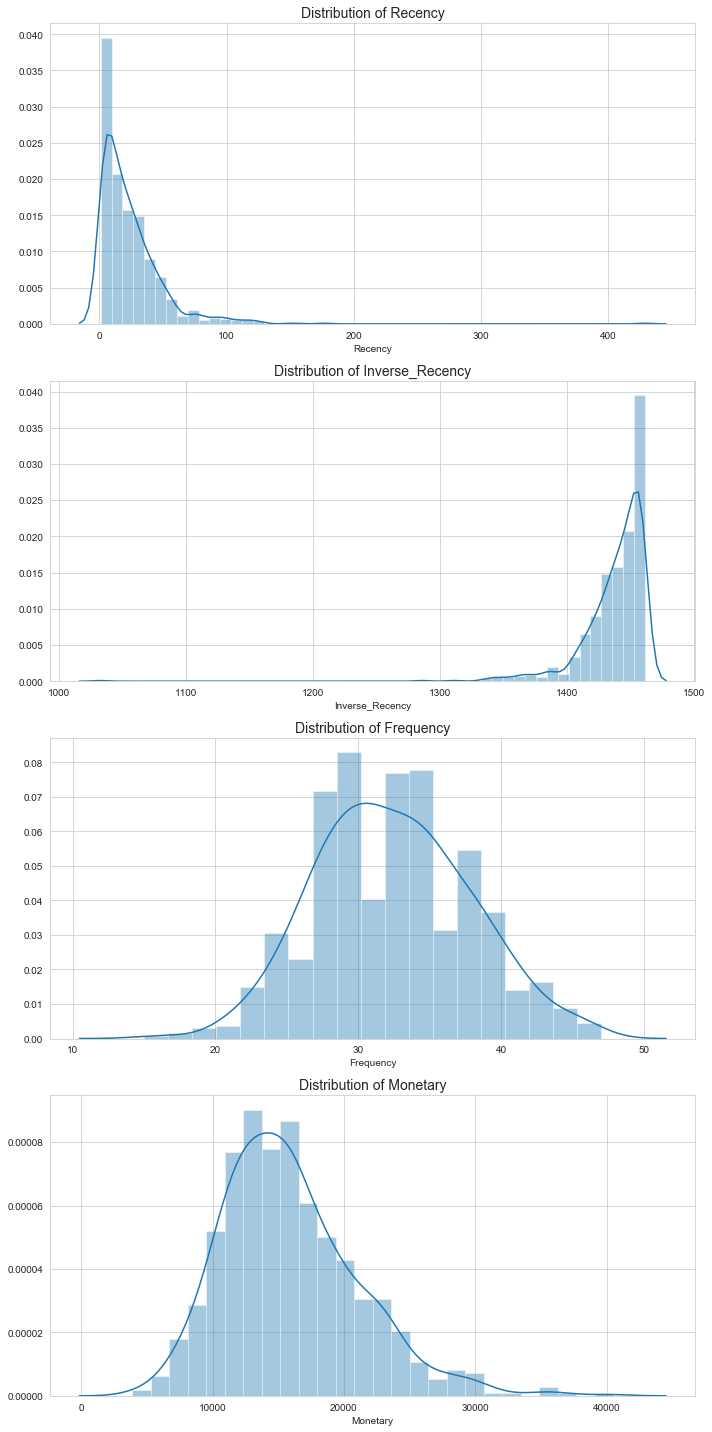

In [9]:
# Distribution of recency, frequency, monetary
fig, ax = plt.subplots(4, 1, figsize = (10, 20))
for idx, val in enumerate(df_rfm.drop('Customer Name', axis = 1)):
    sns.distplot(df_rfm[val], ax = ax[idx])
    ax[idx].set_title(f'Distribution of {val}', fontsize = 14)
plt.tight_layout()

Since we will conduct clustering method, we need to rescale values in each feature. RFM usually divided data into 5 equal parts and scored them from 1 to 5 however I will not do this insted I will standardize the data. It should be noted that Recency is different compared to Frequency and Monetary. While Frequency and Monetary is better when their values are larger, it is opposite with Recency. 

In [10]:
# Calling the scaler model 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [11]:
# Transforming all data
scaled_data = scaler.fit_transform(df_rfm.drop(['Customer Name', 'Recency'], axis = 1))

In [12]:
# Concatenating two dataframes consists of actual data and scaled data
df_rfm_new = pd.concat([df_rfm, pd.DataFrame(scaled_data, index = df_rfm.index, 
                                             columns = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'])], 
                       axis = 1)

df_rfm_new.head()

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale
0,Aaron Bergman,17,1445,37,24644.65,0.268721,0.852053,1.679069
1,Aaron Hawkins,13,1449,34,20759.52,0.414596,0.296973,0.932866
2,Aaron Smayling,24,1438,31,14212.62,0.013441,-0.258106,-0.324572
3,Adam Bellavance,36,1426,41,20186.79,-0.424183,1.592159,0.822864
4,Adam Hart,3,1459,42,21718.24,0.779282,1.777185,1.117004


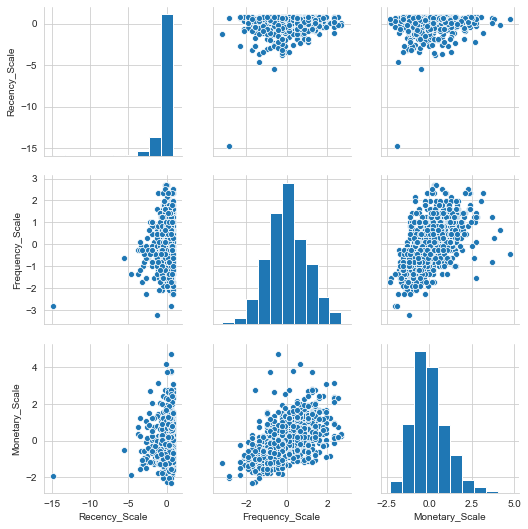

In [13]:
# Visualization of scaled values
sns.pairplot(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])

I noticed that there is one data point that is very far away to other data as shown in the pairplot above. I will drop this data and analyze it separately.

In [14]:
# Looking into one data point that far away to other points
df_rfm_new[df_rfm_new['Recency_Scale'] < -10]

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale
571,Nicole Brennan,429,1033,17,5935.07,-14.756365,-2.848477,-1.914411


In [15]:
# Dropping Nicole Brennan from data
df_rfm_new.drop(index = 571, inplace = True)
df_rfm_new[df_rfm_new['Recency_Scale'] < -10]

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale


In [16]:
# Dropping all scaled value
df_rfm_new.drop(columns = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'], axis = 1, inplace = True)

In [17]:
# Rescaling the data
scaled_data = scaler.fit_transform(df_rfm_new.drop(['Recency', 'Customer Name'], axis = 1))

In [18]:
# Concatenating two dataframes consists of actual data and scaled data
df_rfm_new = pd.concat([df_rfm_new, pd.DataFrame(scaled_data, index = df_rfm_new.index, 
                                                 columns = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'])], 
                       axis = 1)

df_rfm_new.head()

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale
0,Aaron Bergman,17,1445,37,24644.65,0.293433,0.852298,1.679483
1,Aaron Hawkins,13,1449,34,20759.52,0.464557,0.294711,0.932023
2,Aaron Smayling,24,1438,31,14212.62,-0.006035,-0.262876,-0.327535
3,Adam Bellavance,36,1426,41,20186.79,-0.519407,1.595746,0.821836
4,Adam Hart,3,1459,42,21718.24,0.892367,1.781608,1.116472


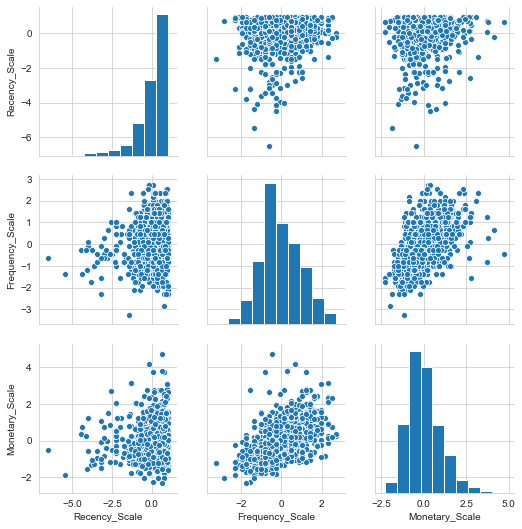

In [19]:
# Visualization of scaled values
sns.pairplot(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])

In [20]:
# Looking into two data points that far away to other points
df_rfm_new[df_rfm_new['Recency_Scale'] < -5]

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale
642,Robert Barroso,151,1311,25,6256.21,-5.439227,-1.378049,-1.858268
699,Shirley Jackson,176,1286,29,13384.85,-6.508753,-0.634600,-0.486789


In [21]:
# Dropping Robert Barroso and Shirley Jackson from data
df_rfm_new.drop(index = [642, 699], inplace = True)
df_rfm_new[df_rfm_new['Recency_Scale'] < -10]

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale


In [22]:
# Dropping all scaled value
df_rfm_new.drop(columns = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'], axis = 1, inplace = True)

In [23]:
# Rescaling the data
scaled_data = scaler.fit_transform(df_rfm_new.drop(['Recency', 'Customer Name'], axis = 1))

In [24]:
# Concatenating two dataframes consists of actual data and scaled data
df_rfm_new = pd.concat([df_rfm_new, pd.DataFrame(scaled_data, index = df_rfm_new.index, 
                                                 columns = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'])], 
                       axis = 1)

df_rfm_new.head()

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale
0,Aaron Bergman,17,1445,37,24644.65,0.291554,0.849921,1.678322
1,Aaron Hawkins,13,1449,34,20759.52,0.470798,0.292226,0.930059
2,Aaron Smayling,24,1438,31,14212.62,-0.022123,-0.265468,-0.330850
3,Adam Bellavance,36,1426,41,20186.79,-0.559854,1.593514,0.819754
4,Adam Hart,3,1459,42,21718.24,0.918908,1.779412,1.114706


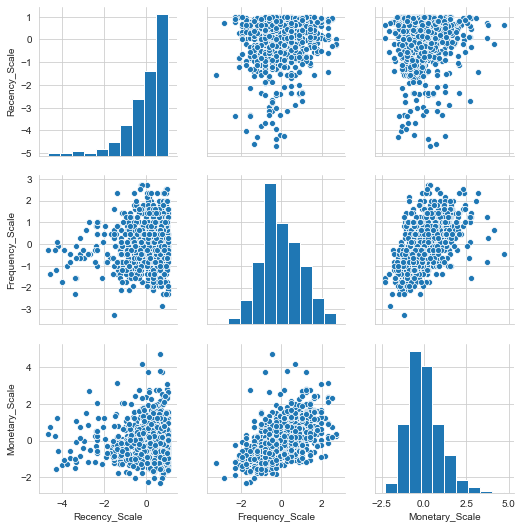

In [25]:
# Visualization of scaled values
sns.pairplot(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])

In [26]:
# Dropping 'Inverse_Recency' feature
df_rfm_new.drop('Inverse_Recency', axis = 1, inplace = True)
df_rfm_new.reset_index(drop = True, inplace = True)

# 3. Clustering

## 3.1. Clustering (Non-PCA)

### 3.1.1. K-means Clustering

In [27]:
# Importing libraries
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'Plot of Recency, Frequency, and Monetary')

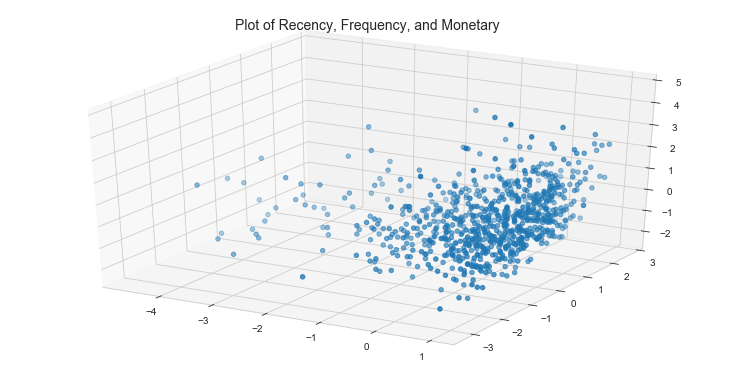

In [28]:
# Plotting the data
fig = plt.figure(figsize = (10, 5))
ax = Axes3D(fig)
ax.scatter(xs = df_rfm_new['Recency_Scale'], 
           ys = df_rfm_new['Frequency_Scale'], 
           zs = df_rfm_new['Monetary_Scale'])
ax.set_title('Plot of Recency, Frequency, and Monetary', fontsize = 14)

Text(0, 0.5, 'Inertia')

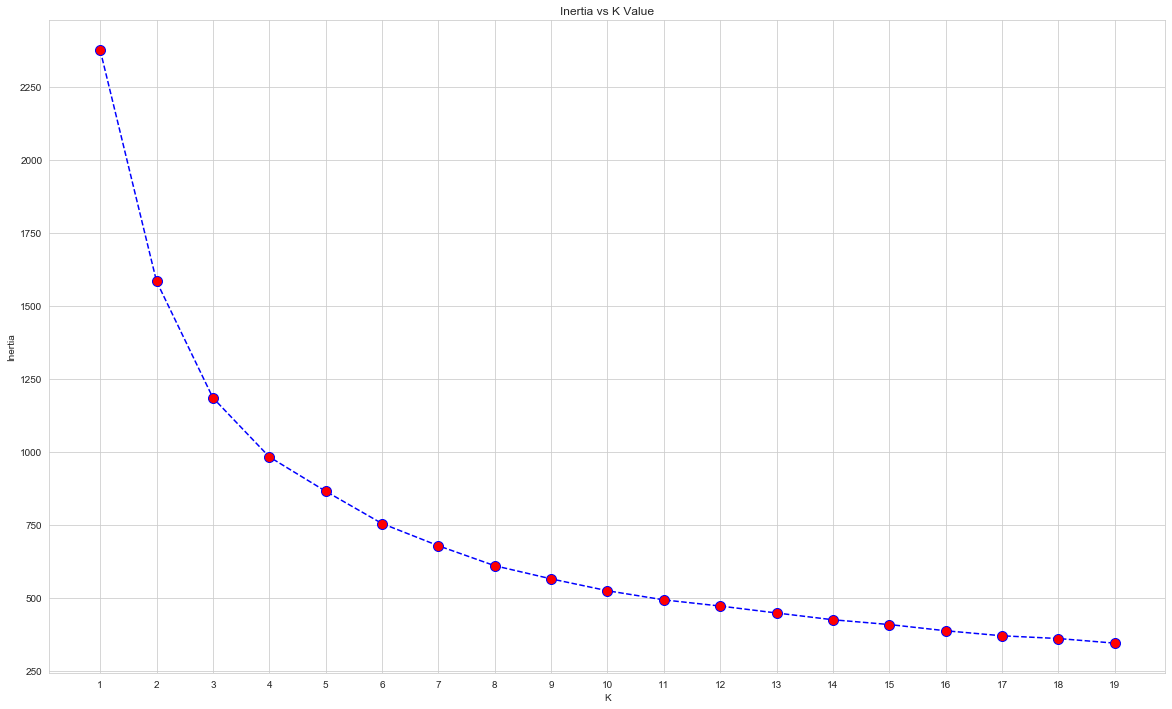

In [29]:
# Elbow method to determine number of k
inertia_list = list()

for i in range(1, 20):
    km = KMeans(n_clusters = i)
    km.fit(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])
    inertia_list.append(km.inertia_)
    
plt.figure(figsize = (20, 12))
plt.plot(range(1, 20), inertia_list, color = 'blue', linestyle = 'dashed', 
         marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Inertia vs K Value')
plt.xticks(range(1, 20))
plt.xlabel('K')
plt.ylabel('Inertia')

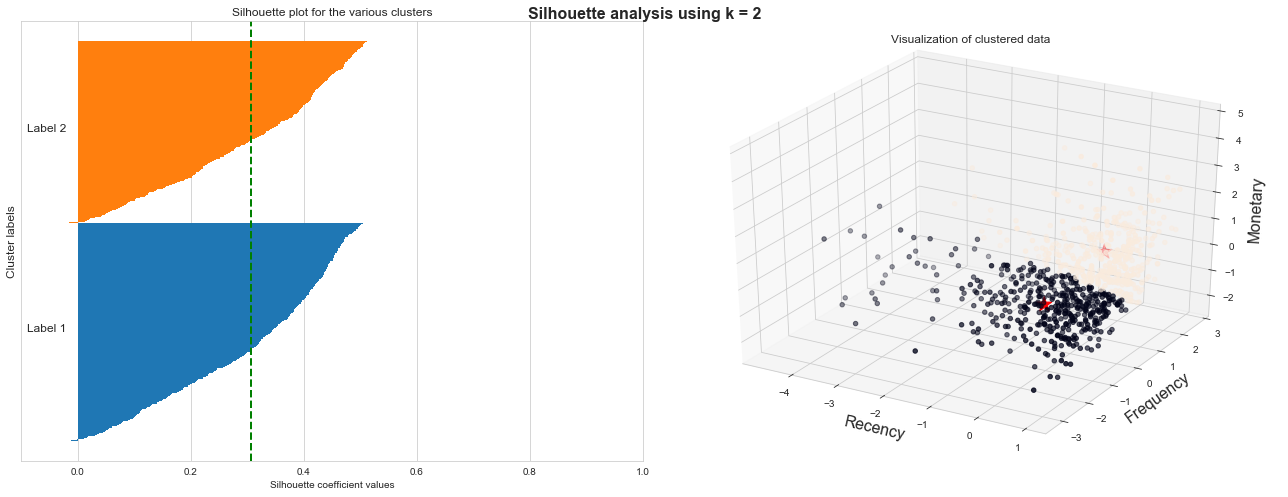

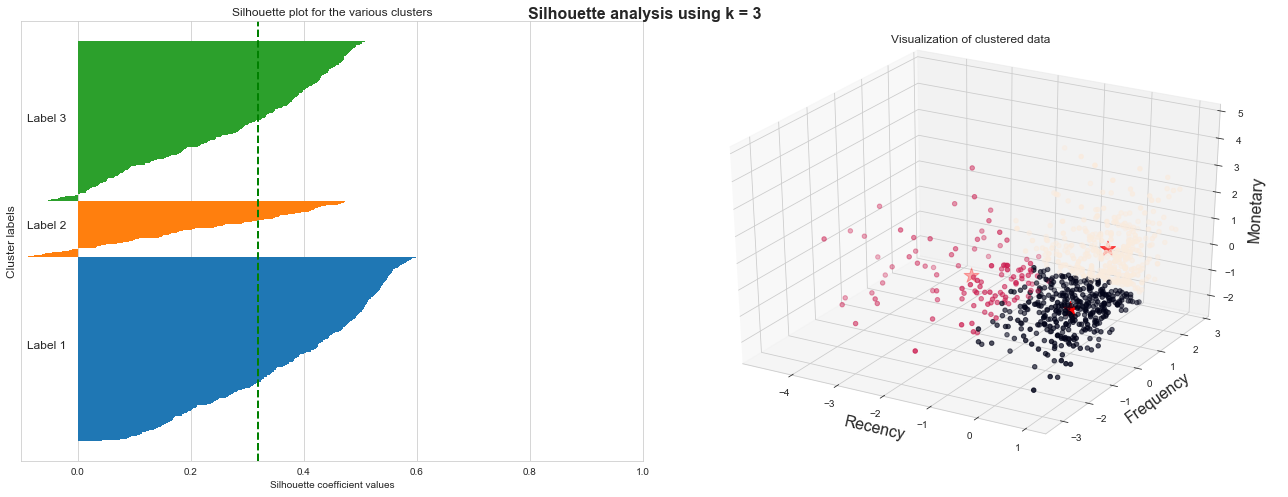

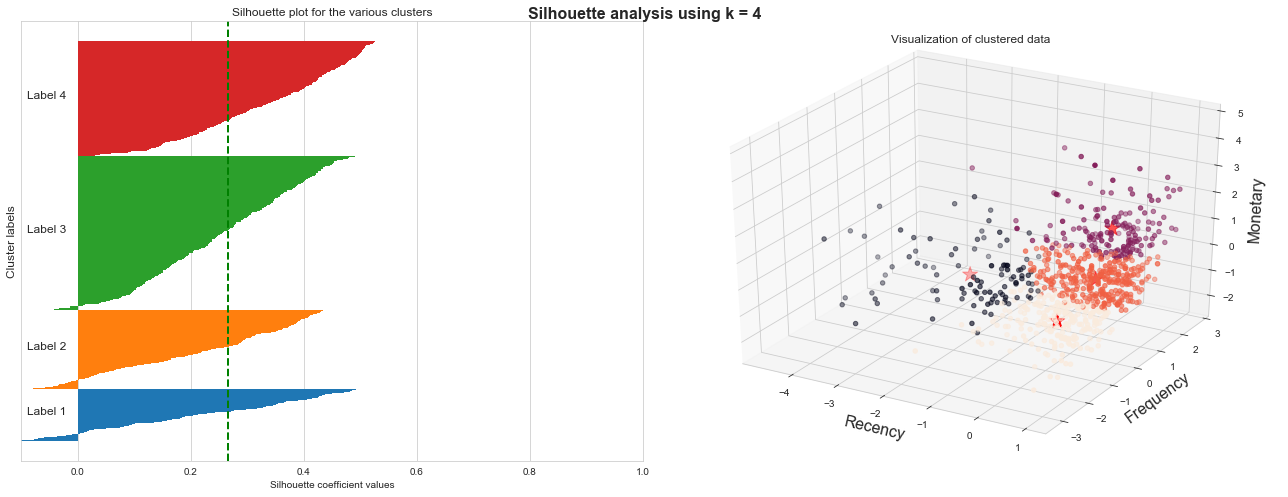

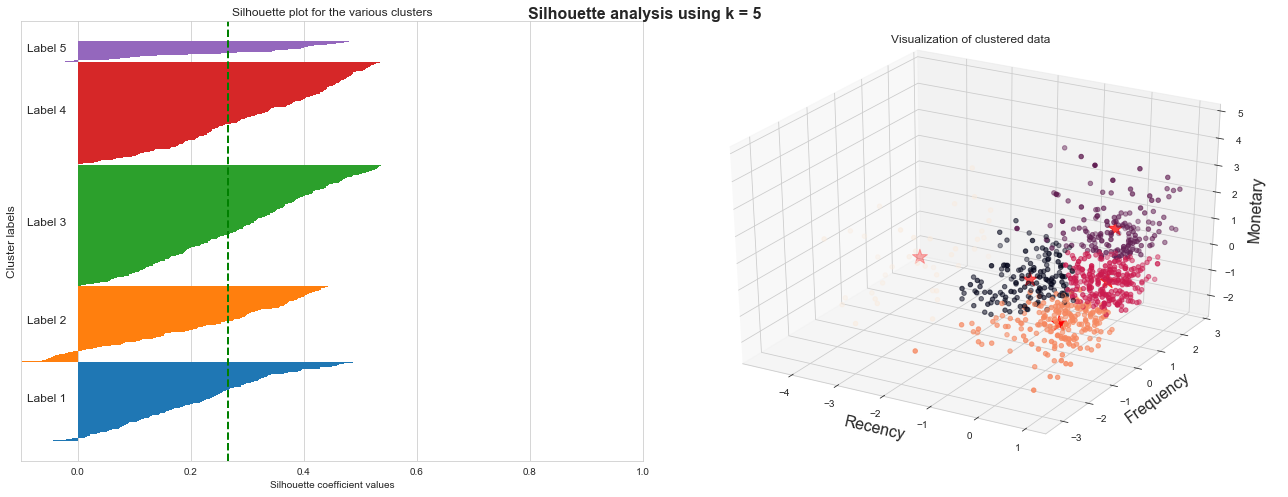

In [30]:
# Making silhouette chart
from sklearn.metrics import silhouette_samples

for i, k in enumerate(list(range(2, 6))):
    fig = plt.figure()
    fig.set_size_inches(18, 7)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection = '3d')
    
    ## Run the Kmeans algorithm
    km = KMeans(n_clusters = k)
    labels = km.fit_predict(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])
    centroids = km.cluster_centers_

    ## Get silhouette samples
    silhouette_vals = silhouette_samples(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']], labels)

    ## Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height = 1)
        ax1.text(-0.09, (y_lower + y_upper) / 2, 'Label '+str(i + 1), fontsize = 12)
        y_lower += len(cluster_silhouette_vals)

    ## Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels', fontsize = 12)
    ax1.set_title('Silhouette plot for the various clusters');
    
    ## Scatter plot of data colored with labels
    ax2.scatter(xs = df_rfm_new['Recency_Scale'], ys = df_rfm_new['Frequency_Scale'], zs = df_rfm_new['Monetary_Scale'], 
                c = labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker = '*', c = 'r', s = 250)
    ax2.set_xlabel('Recency', fontsize = 16)
    ax2.set_ylabel('Frequency', fontsize = 16)
    ax2.set_zlabel('Monetary', fontsize = 16)
    ax2.set_title('Visualization of clustered data', y=1.02)
    plt.tight_layout()
    plt.suptitle('Silhouette analysis using k = {}'.format(k),
                 fontsize=16, fontweight='semibold')

### 3.1.2. DBSCAN

In [31]:
# Hyperparameter tuning for DBSCAN
from sklearn.cluster import DBSCAN
score_dbscan = []

for num in range(2, 50):
    for eps in np.linspace(0.01, 1, 100):
        dbscan = DBSCAN(eps = eps, min_samples = num).fit(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])
        labels = dbscan.labels_
        try:
            s_score = silhouette_score(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']], labels)
            print('Average Silhouette Score for eps = {} and min samples {} is {}'.format(eps, num, s_score))
            score_dbscan.append({'min_sample': num, 'epsilon': eps, 'score': s_score})
        except:
            print('eps = {} and min samples {} result in only 1 Label'.format(eps, num))

eps = 0.01 and min samples 2 result in only 1 Label
eps = 0.02 and min samples 2 result in only 1 Label
eps = 0.03 and min samples 2 result in only 1 Label
eps = 0.04 and min samples 2 result in only 1 Label
eps = 0.05 and min samples 2 result in only 1 Label
eps = 0.060000000000000005 and min samples 2 result in only 1 Label
eps = 0.06999999999999999 and min samples 2 result in only 1 Label
eps = 0.08 and min samples 2 result in only 1 Label
eps = 0.09 and min samples 2 result in only 1 Label
eps = 0.09999999999999999 and min samples 2 result in only 1 Label
eps = 0.11 and min samples 2 result in only 1 Label
eps = 0.12 and min samples 2 result in only 1 Label
eps = 0.13 and min samples 2 result in only 1 Label
eps = 0.14 and min samples 2 result in only 1 Label
eps = 0.15000000000000002 and min samples 2 result in only 1 Label
eps = 0.16 and min samples 2 result in only 1 Label
eps = 0.17 and min samples 2 result in only 1 Label
eps = 0.18000000000000002 and min samples 2 result in o

eps = 0.5800000000000001 and min samples 3 result in only 1 Label
eps = 0.59 and min samples 3 result in only 1 Label
eps = 0.6 and min samples 3 result in only 1 Label
eps = 0.61 and min samples 3 result in only 1 Label
eps = 0.62 and min samples 3 result in only 1 Label
eps = 0.63 and min samples 3 result in only 1 Label
eps = 0.64 and min samples 3 result in only 1 Label
eps = 0.65 and min samples 3 result in only 1 Label
eps = 0.66 and min samples 3 result in only 1 Label
eps = 0.67 and min samples 3 result in only 1 Label
eps = 0.68 and min samples 3 result in only 1 Label
eps = 0.6900000000000001 and min samples 3 result in only 1 Label
eps = 0.7000000000000001 and min samples 3 result in only 1 Label
eps = 0.7100000000000001 and min samples 3 result in only 1 Label
eps = 0.72 and min samples 3 result in only 1 Label
eps = 0.73 and min samples 3 result in only 1 Label
eps = 0.74 and min samples 3 result in only 1 Label
eps = 0.75 and min samples 3 result in only 1 Label
eps = 0.7

eps = 0.27 and min samples 5 result in only 1 Label
eps = 0.28 and min samples 5 result in only 1 Label
eps = 0.29000000000000004 and min samples 5 result in only 1 Label
eps = 0.3 and min samples 5 result in only 1 Label
eps = 0.31 and min samples 5 result in only 1 Label
eps = 0.32 and min samples 5 result in only 1 Label
eps = 0.33 and min samples 5 result in only 1 Label
eps = 0.34 and min samples 5 result in only 1 Label
eps = 0.35000000000000003 and min samples 5 result in only 1 Label
eps = 0.36000000000000004 and min samples 5 result in only 1 Label
eps = 0.37 and min samples 5 result in only 1 Label
eps = 0.38 and min samples 5 result in only 1 Label
eps = 0.39 and min samples 5 result in only 1 Label
eps = 0.4 and min samples 5 result in only 1 Label
eps = 0.41000000000000003 and min samples 5 result in only 1 Label
eps = 0.42000000000000004 and min samples 5 result in only 1 Label
eps = 0.43 and min samples 5 result in only 1 Label
eps = 0.44 and min samples 5 result in only

eps = 0.85 and min samples 6 result in only 1 Label
eps = 0.86 and min samples 6 result in only 1 Label
eps = 0.87 and min samples 6 result in only 1 Label
eps = 0.88 and min samples 6 result in only 1 Label
eps = 0.89 and min samples 6 result in only 1 Label
eps = 0.9 and min samples 6 result in only 1 Label
eps = 0.91 and min samples 6 result in only 1 Label
eps = 0.92 and min samples 6 result in only 1 Label
eps = 0.93 and min samples 6 result in only 1 Label
eps = 0.9400000000000001 and min samples 6 result in only 1 Label
eps = 0.9500000000000001 and min samples 6 result in only 1 Label
eps = 0.9600000000000001 and min samples 6 result in only 1 Label
eps = 0.97 and min samples 6 result in only 1 Label
eps = 0.98 and min samples 6 result in only 1 Label
eps = 0.99 and min samples 6 result in only 1 Label
eps = 1.0 and min samples 6 result in only 1 Label
eps = 0.01 and min samples 7 result in only 1 Label
eps = 0.02 and min samples 7 result in only 1 Label
eps = 0.03 and min sampl

eps = 0.34 and min samples 8 result in only 1 Label
eps = 0.35000000000000003 and min samples 8 result in only 1 Label
eps = 0.36000000000000004 and min samples 8 result in only 1 Label
eps = 0.37 and min samples 8 result in only 1 Label
eps = 0.38 and min samples 8 result in only 1 Label
eps = 0.39 and min samples 8 result in only 1 Label
eps = 0.4 and min samples 8 result in only 1 Label
eps = 0.41000000000000003 and min samples 8 result in only 1 Label
eps = 0.42000000000000004 and min samples 8 result in only 1 Label
eps = 0.43 and min samples 8 result in only 1 Label
eps = 0.44 and min samples 8 result in only 1 Label
eps = 0.45 and min samples 8 result in only 1 Label
eps = 0.46 and min samples 8 result in only 1 Label
eps = 0.47000000000000003 and min samples 8 result in only 1 Label
eps = 0.48000000000000004 and min samples 8 result in only 1 Label
eps = 0.49 and min samples 8 result in only 1 Label
eps = 0.5 and min samples 8 result in only 1 Label
eps = 0.51 and min samples 8

eps = 0.8400000000000001 and min samples 9 result in only 1 Label
eps = 0.85 and min samples 9 result in only 1 Label
eps = 0.86 and min samples 9 result in only 1 Label
eps = 0.87 and min samples 9 result in only 1 Label
eps = 0.88 and min samples 9 result in only 1 Label
eps = 0.89 and min samples 9 result in only 1 Label
eps = 0.9 and min samples 9 result in only 1 Label
eps = 0.91 and min samples 9 result in only 1 Label
eps = 0.92 and min samples 9 result in only 1 Label
eps = 0.93 and min samples 9 result in only 1 Label
eps = 0.9400000000000001 and min samples 9 result in only 1 Label
eps = 0.9500000000000001 and min samples 9 result in only 1 Label
eps = 0.9600000000000001 and min samples 9 result in only 1 Label
eps = 0.97 and min samples 9 result in only 1 Label
eps = 0.98 and min samples 9 result in only 1 Label
eps = 0.99 and min samples 9 result in only 1 Label
eps = 1.0 and min samples 9 result in only 1 Label
eps = 0.01 and min samples 10 result in only 1 Label
eps = 0.0

eps = 0.32 and min samples 11 result in only 1 Label
eps = 0.33 and min samples 11 result in only 1 Label
eps = 0.34 and min samples 11 result in only 1 Label
eps = 0.35000000000000003 and min samples 11 result in only 1 Label
eps = 0.36000000000000004 and min samples 11 result in only 1 Label
eps = 0.37 and min samples 11 result in only 1 Label
eps = 0.38 and min samples 11 result in only 1 Label
eps = 0.39 and min samples 11 result in only 1 Label
eps = 0.4 and min samples 11 result in only 1 Label
eps = 0.41000000000000003 and min samples 11 result in only 1 Label
eps = 0.42000000000000004 and min samples 11 result in only 1 Label
eps = 0.43 and min samples 11 result in only 1 Label
eps = 0.44 and min samples 11 result in only 1 Label
eps = 0.45 and min samples 11 result in only 1 Label
eps = 0.46 and min samples 11 result in only 1 Label
eps = 0.47000000000000003 and min samples 11 result in only 1 Label
eps = 0.48000000000000004 and min samples 11 result in only 1 Label
eps = 0.49

eps = 0.78 and min samples 12 result in only 1 Label
eps = 0.79 and min samples 12 result in only 1 Label
eps = 0.8 and min samples 12 result in only 1 Label
eps = 0.81 and min samples 12 result in only 1 Label
eps = 0.8200000000000001 and min samples 12 result in only 1 Label
eps = 0.8300000000000001 and min samples 12 result in only 1 Label
eps = 0.8400000000000001 and min samples 12 result in only 1 Label
eps = 0.85 and min samples 12 result in only 1 Label
eps = 0.86 and min samples 12 result in only 1 Label
eps = 0.87 and min samples 12 result in only 1 Label
eps = 0.88 and min samples 12 result in only 1 Label
eps = 0.89 and min samples 12 result in only 1 Label
eps = 0.9 and min samples 12 result in only 1 Label
eps = 0.91 and min samples 12 result in only 1 Label
eps = 0.92 and min samples 12 result in only 1 Label
eps = 0.93 and min samples 12 result in only 1 Label
eps = 0.9400000000000001 and min samples 12 result in only 1 Label
eps = 0.9500000000000001 and min samples 12 r

eps = 0.31 and min samples 14 result in only 1 Label
eps = 0.32 and min samples 14 result in only 1 Label
eps = 0.33 and min samples 14 result in only 1 Label
eps = 0.34 and min samples 14 result in only 1 Label
eps = 0.35000000000000003 and min samples 14 result in only 1 Label
eps = 0.36000000000000004 and min samples 14 result in only 1 Label
eps = 0.37 and min samples 14 result in only 1 Label
eps = 0.38 and min samples 14 result in only 1 Label
eps = 0.39 and min samples 14 result in only 1 Label
eps = 0.4 and min samples 14 result in only 1 Label
eps = 0.41000000000000003 and min samples 14 result in only 1 Label
eps = 0.42000000000000004 and min samples 14 result in only 1 Label
eps = 0.43 and min samples 14 result in only 1 Label
eps = 0.44 and min samples 14 result in only 1 Label
eps = 0.45 and min samples 14 result in only 1 Label
eps = 0.46 and min samples 14 result in only 1 Label
eps = 0.47000000000000003 and min samples 14 result in only 1 Label
eps = 0.48000000000000004

eps = 0.75 and min samples 15 result in only 1 Label
eps = 0.76 and min samples 15 result in only 1 Label
eps = 0.77 and min samples 15 result in only 1 Label
eps = 0.78 and min samples 15 result in only 1 Label
eps = 0.79 and min samples 15 result in only 1 Label
eps = 0.8 and min samples 15 result in only 1 Label
eps = 0.81 and min samples 15 result in only 1 Label
eps = 0.8200000000000001 and min samples 15 result in only 1 Label
eps = 0.8300000000000001 and min samples 15 result in only 1 Label
eps = 0.8400000000000001 and min samples 15 result in only 1 Label
eps = 0.85 and min samples 15 result in only 1 Label
eps = 0.86 and min samples 15 result in only 1 Label
eps = 0.87 and min samples 15 result in only 1 Label
eps = 0.88 and min samples 15 result in only 1 Label
eps = 0.89 and min samples 15 result in only 1 Label
eps = 0.9 and min samples 15 result in only 1 Label
eps = 0.91 and min samples 15 result in only 1 Label
eps = 0.92 and min samples 15 result in only 1 Label
eps = 

eps = 0.23 and min samples 17 result in only 1 Label
eps = 0.24000000000000002 and min samples 17 result in only 1 Label
eps = 0.25 and min samples 17 result in only 1 Label
eps = 0.26 and min samples 17 result in only 1 Label
eps = 0.27 and min samples 17 result in only 1 Label
eps = 0.28 and min samples 17 result in only 1 Label
eps = 0.29000000000000004 and min samples 17 result in only 1 Label
eps = 0.3 and min samples 17 result in only 1 Label
eps = 0.31 and min samples 17 result in only 1 Label
eps = 0.32 and min samples 17 result in only 1 Label
eps = 0.33 and min samples 17 result in only 1 Label
eps = 0.34 and min samples 17 result in only 1 Label
eps = 0.35000000000000003 and min samples 17 result in only 1 Label
eps = 0.36000000000000004 and min samples 17 result in only 1 Label
eps = 0.37 and min samples 17 result in only 1 Label
eps = 0.38 and min samples 17 result in only 1 Label
eps = 0.39 and min samples 17 result in only 1 Label
eps = 0.4 and min samples 17 result in o

eps = 0.6900000000000001 and min samples 18 result in only 1 Label
eps = 0.7000000000000001 and min samples 18 result in only 1 Label
eps = 0.7100000000000001 and min samples 18 result in only 1 Label
eps = 0.72 and min samples 18 result in only 1 Label
eps = 0.73 and min samples 18 result in only 1 Label
eps = 0.74 and min samples 18 result in only 1 Label
eps = 0.75 and min samples 18 result in only 1 Label
eps = 0.76 and min samples 18 result in only 1 Label
eps = 0.77 and min samples 18 result in only 1 Label
eps = 0.78 and min samples 18 result in only 1 Label
eps = 0.79 and min samples 18 result in only 1 Label
eps = 0.8 and min samples 18 result in only 1 Label
eps = 0.81 and min samples 18 result in only 1 Label
eps = 0.8200000000000001 and min samples 18 result in only 1 Label
eps = 0.8300000000000001 and min samples 18 result in only 1 Label
eps = 0.8400000000000001 and min samples 18 result in only 1 Label
eps = 0.85 and min samples 18 result in only 1 Label
eps = 0.86 and m

eps = 0.21000000000000002 and min samples 20 result in only 1 Label
eps = 0.22 and min samples 20 result in only 1 Label
eps = 0.23 and min samples 20 result in only 1 Label
eps = 0.24000000000000002 and min samples 20 result in only 1 Label
eps = 0.25 and min samples 20 result in only 1 Label
eps = 0.26 and min samples 20 result in only 1 Label
eps = 0.27 and min samples 20 result in only 1 Label
eps = 0.28 and min samples 20 result in only 1 Label
eps = 0.29000000000000004 and min samples 20 result in only 1 Label
eps = 0.3 and min samples 20 result in only 1 Label
eps = 0.31 and min samples 20 result in only 1 Label
eps = 0.32 and min samples 20 result in only 1 Label
eps = 0.33 and min samples 20 result in only 1 Label
eps = 0.34 and min samples 20 result in only 1 Label
eps = 0.35000000000000003 and min samples 20 result in only 1 Label
eps = 0.36000000000000004 and min samples 20 result in only 1 Label
eps = 0.37 and min samples 20 result in only 1 Label
eps = 0.38 and min sample

eps = 0.66 and min samples 21 result in only 1 Label
eps = 0.67 and min samples 21 result in only 1 Label
eps = 0.68 and min samples 21 result in only 1 Label
eps = 0.6900000000000001 and min samples 21 result in only 1 Label
eps = 0.7000000000000001 and min samples 21 result in only 1 Label
eps = 0.7100000000000001 and min samples 21 result in only 1 Label
eps = 0.72 and min samples 21 result in only 1 Label
eps = 0.73 and min samples 21 result in only 1 Label
eps = 0.74 and min samples 21 result in only 1 Label
eps = 0.75 and min samples 21 result in only 1 Label
eps = 0.76 and min samples 21 result in only 1 Label
eps = 0.77 and min samples 21 result in only 1 Label
eps = 0.78 and min samples 21 result in only 1 Label
eps = 0.79 and min samples 21 result in only 1 Label
eps = 0.8 and min samples 21 result in only 1 Label
eps = 0.81 and min samples 21 result in only 1 Label
eps = 0.8200000000000001 and min samples 21 result in only 1 Label
eps = 0.8300000000000001 and min samples 21 

eps = 0.32 and min samples 23 result in only 1 Label
eps = 0.33 and min samples 23 result in only 1 Label
eps = 0.34 and min samples 23 result in only 1 Label
eps = 0.35000000000000003 and min samples 23 result in only 1 Label
eps = 0.36000000000000004 and min samples 23 result in only 1 Label
eps = 0.37 and min samples 23 result in only 1 Label
eps = 0.38 and min samples 23 result in only 1 Label
eps = 0.39 and min samples 23 result in only 1 Label
eps = 0.4 and min samples 23 result in only 1 Label
eps = 0.41000000000000003 and min samples 23 result in only 1 Label
eps = 0.42000000000000004 and min samples 23 result in only 1 Label
eps = 0.43 and min samples 23 result in only 1 Label
eps = 0.44 and min samples 23 result in only 1 Label
eps = 0.45 and min samples 23 result in only 1 Label
eps = 0.46 and min samples 23 result in only 1 Label
eps = 0.47000000000000003 and min samples 23 result in only 1 Label
eps = 0.48000000000000004 and min samples 23 result in only 1 Label
eps = 0.49

eps = 0.89 and min samples 24 result in only 1 Label
eps = 0.9 and min samples 24 result in only 1 Label
eps = 0.91 and min samples 24 result in only 1 Label
eps = 0.92 and min samples 24 result in only 1 Label
eps = 0.93 and min samples 24 result in only 1 Label
eps = 0.9400000000000001 and min samples 24 result in only 1 Label
eps = 0.9500000000000001 and min samples 24 result in only 1 Label
eps = 0.9600000000000001 and min samples 24 result in only 1 Label
eps = 0.97 and min samples 24 result in only 1 Label
eps = 0.98 and min samples 24 result in only 1 Label
eps = 0.99 and min samples 24 result in only 1 Label
eps = 1.0 and min samples 24 result in only 1 Label
eps = 0.01 and min samples 25 result in only 1 Label
eps = 0.02 and min samples 25 result in only 1 Label
eps = 0.03 and min samples 25 result in only 1 Label
eps = 0.04 and min samples 25 result in only 1 Label
eps = 0.05 and min samples 25 result in only 1 Label
eps = 0.060000000000000005 and min samples 25 result in onl

eps = 0.43 and min samples 26 result in only 1 Label
eps = 0.44 and min samples 26 result in only 1 Label
eps = 0.45 and min samples 26 result in only 1 Label
eps = 0.46 and min samples 26 result in only 1 Label
eps = 0.47000000000000003 and min samples 26 result in only 1 Label
eps = 0.48000000000000004 and min samples 26 result in only 1 Label
eps = 0.49 and min samples 26 result in only 1 Label
eps = 0.5 and min samples 26 result in only 1 Label
eps = 0.51 and min samples 26 result in only 1 Label
eps = 0.52 and min samples 26 result in only 1 Label
eps = 0.53 and min samples 26 result in only 1 Label
eps = 0.54 and min samples 26 result in only 1 Label
eps = 0.55 and min samples 26 result in only 1 Label
eps = 0.56 and min samples 26 result in only 1 Label
eps = 0.5700000000000001 and min samples 26 result in only 1 Label
eps = 0.5800000000000001 and min samples 26 result in only 1 Label
eps = 0.59 and min samples 26 result in only 1 Label
eps = 0.6 and min samples 26 result in onl

eps = 1.0 and min samples 27 result in only 1 Label
eps = 0.01 and min samples 28 result in only 1 Label
eps = 0.02 and min samples 28 result in only 1 Label
eps = 0.03 and min samples 28 result in only 1 Label
eps = 0.04 and min samples 28 result in only 1 Label
eps = 0.05 and min samples 28 result in only 1 Label
eps = 0.060000000000000005 and min samples 28 result in only 1 Label
eps = 0.06999999999999999 and min samples 28 result in only 1 Label
eps = 0.08 and min samples 28 result in only 1 Label
eps = 0.09 and min samples 28 result in only 1 Label
eps = 0.09999999999999999 and min samples 28 result in only 1 Label
eps = 0.11 and min samples 28 result in only 1 Label
eps = 0.12 and min samples 28 result in only 1 Label
eps = 0.13 and min samples 28 result in only 1 Label
eps = 0.14 and min samples 28 result in only 1 Label
eps = 0.15000000000000002 and min samples 28 result in only 1 Label
eps = 0.16 and min samples 28 result in only 1 Label
eps = 0.17 and min samples 28 result in

eps = 0.6 and min samples 29 result in only 1 Label
eps = 0.61 and min samples 29 result in only 1 Label
eps = 0.62 and min samples 29 result in only 1 Label
eps = 0.63 and min samples 29 result in only 1 Label
eps = 0.64 and min samples 29 result in only 1 Label
eps = 0.65 and min samples 29 result in only 1 Label
eps = 0.66 and min samples 29 result in only 1 Label
eps = 0.67 and min samples 29 result in only 1 Label
eps = 0.68 and min samples 29 result in only 1 Label
eps = 0.6900000000000001 and min samples 29 result in only 1 Label
eps = 0.7000000000000001 and min samples 29 result in only 1 Label
eps = 0.7100000000000001 and min samples 29 result in only 1 Label
eps = 0.72 and min samples 29 result in only 1 Label
eps = 0.73 and min samples 29 result in only 1 Label
eps = 0.74 and min samples 29 result in only 1 Label
eps = 0.75 and min samples 29 result in only 1 Label
eps = 0.76 and min samples 29 result in only 1 Label
eps = 0.77 and min samples 29 result in only 1 Label
eps =

eps = 0.23 and min samples 31 result in only 1 Label
eps = 0.24000000000000002 and min samples 31 result in only 1 Label
eps = 0.25 and min samples 31 result in only 1 Label
eps = 0.26 and min samples 31 result in only 1 Label
eps = 0.27 and min samples 31 result in only 1 Label
eps = 0.28 and min samples 31 result in only 1 Label
eps = 0.29000000000000004 and min samples 31 result in only 1 Label
eps = 0.3 and min samples 31 result in only 1 Label
eps = 0.31 and min samples 31 result in only 1 Label
eps = 0.32 and min samples 31 result in only 1 Label
eps = 0.33 and min samples 31 result in only 1 Label
eps = 0.34 and min samples 31 result in only 1 Label
eps = 0.35000000000000003 and min samples 31 result in only 1 Label
eps = 0.36000000000000004 and min samples 31 result in only 1 Label
eps = 0.37 and min samples 31 result in only 1 Label
eps = 0.38 and min samples 31 result in only 1 Label
eps = 0.39 and min samples 31 result in only 1 Label
eps = 0.4 and min samples 31 result in o

eps = 0.73 and min samples 32 result in only 1 Label
eps = 0.74 and min samples 32 result in only 1 Label
eps = 0.75 and min samples 32 result in only 1 Label
eps = 0.76 and min samples 32 result in only 1 Label
eps = 0.77 and min samples 32 result in only 1 Label
eps = 0.78 and min samples 32 result in only 1 Label
eps = 0.79 and min samples 32 result in only 1 Label
eps = 0.8 and min samples 32 result in only 1 Label
eps = 0.81 and min samples 32 result in only 1 Label
eps = 0.8200000000000001 and min samples 32 result in only 1 Label
eps = 0.8300000000000001 and min samples 32 result in only 1 Label
eps = 0.8400000000000001 and min samples 32 result in only 1 Label
eps = 0.85 and min samples 32 result in only 1 Label
eps = 0.86 and min samples 32 result in only 1 Label
eps = 0.87 and min samples 32 result in only 1 Label
eps = 0.88 and min samples 32 result in only 1 Label
eps = 0.89 and min samples 32 result in only 1 Label
eps = 0.9 and min samples 32 result in only 1 Label
eps = 

eps = 0.38 and min samples 34 result in only 1 Label
eps = 0.39 and min samples 34 result in only 1 Label
eps = 0.4 and min samples 34 result in only 1 Label
eps = 0.41000000000000003 and min samples 34 result in only 1 Label
eps = 0.42000000000000004 and min samples 34 result in only 1 Label
eps = 0.43 and min samples 34 result in only 1 Label
eps = 0.44 and min samples 34 result in only 1 Label
eps = 0.45 and min samples 34 result in only 1 Label
eps = 0.46 and min samples 34 result in only 1 Label
eps = 0.47000000000000003 and min samples 34 result in only 1 Label
eps = 0.48000000000000004 and min samples 34 result in only 1 Label
eps = 0.49 and min samples 34 result in only 1 Label
eps = 0.5 and min samples 34 result in only 1 Label
eps = 0.51 and min samples 34 result in only 1 Label
eps = 0.52 and min samples 34 result in only 1 Label
eps = 0.53 and min samples 34 result in only 1 Label
eps = 0.54 and min samples 34 result in only 1 Label
eps = 0.55 and min samples 34 result in o

eps = 0.9400000000000001 and min samples 35 result in only 1 Label
eps = 0.9500000000000001 and min samples 35 result in only 1 Label
eps = 0.9600000000000001 and min samples 35 result in only 1 Label
eps = 0.97 and min samples 35 result in only 1 Label
eps = 0.98 and min samples 35 result in only 1 Label
eps = 0.99 and min samples 35 result in only 1 Label
eps = 1.0 and min samples 35 result in only 1 Label
eps = 0.01 and min samples 36 result in only 1 Label
eps = 0.02 and min samples 36 result in only 1 Label
eps = 0.03 and min samples 36 result in only 1 Label
eps = 0.04 and min samples 36 result in only 1 Label
eps = 0.05 and min samples 36 result in only 1 Label
eps = 0.060000000000000005 and min samples 36 result in only 1 Label
eps = 0.06999999999999999 and min samples 36 result in only 1 Label
eps = 0.08 and min samples 36 result in only 1 Label
eps = 0.09 and min samples 36 result in only 1 Label
eps = 0.09999999999999999 and min samples 36 result in only 1 Label
eps = 0.11 a

eps = 0.49 and min samples 37 result in only 1 Label
eps = 0.5 and min samples 37 result in only 1 Label
eps = 0.51 and min samples 37 result in only 1 Label
eps = 0.52 and min samples 37 result in only 1 Label
eps = 0.53 and min samples 37 result in only 1 Label
eps = 0.54 and min samples 37 result in only 1 Label
eps = 0.55 and min samples 37 result in only 1 Label
eps = 0.56 and min samples 37 result in only 1 Label
eps = 0.5700000000000001 and min samples 37 result in only 1 Label
eps = 0.5800000000000001 and min samples 37 result in only 1 Label
eps = 0.59 and min samples 37 result in only 1 Label
eps = 0.6 and min samples 37 result in only 1 Label
eps = 0.61 and min samples 37 result in only 1 Label
eps = 0.62 and min samples 37 result in only 1 Label
eps = 0.63 and min samples 37 result in only 1 Label
eps = 0.64 and min samples 37 result in only 1 Label
eps = 0.65 and min samples 37 result in only 1 Label
eps = 0.66 and min samples 37 result in only 1 Label
eps = 0.67 and min s

eps = 0.06999999999999999 and min samples 39 result in only 1 Label
eps = 0.08 and min samples 39 result in only 1 Label
eps = 0.09 and min samples 39 result in only 1 Label
eps = 0.09999999999999999 and min samples 39 result in only 1 Label
eps = 0.11 and min samples 39 result in only 1 Label
eps = 0.12 and min samples 39 result in only 1 Label
eps = 0.13 and min samples 39 result in only 1 Label
eps = 0.14 and min samples 39 result in only 1 Label
eps = 0.15000000000000002 and min samples 39 result in only 1 Label
eps = 0.16 and min samples 39 result in only 1 Label
eps = 0.17 and min samples 39 result in only 1 Label
eps = 0.18000000000000002 and min samples 39 result in only 1 Label
eps = 0.19 and min samples 39 result in only 1 Label
eps = 0.2 and min samples 39 result in only 1 Label
eps = 0.21000000000000002 and min samples 39 result in only 1 Label
eps = 0.22 and min samples 39 result in only 1 Label
eps = 0.23 and min samples 39 result in only 1 Label
eps = 0.24000000000000002

eps = 0.66 and min samples 40 result in only 1 Label
eps = 0.67 and min samples 40 result in only 1 Label
eps = 0.68 and min samples 40 result in only 1 Label
eps = 0.6900000000000001 and min samples 40 result in only 1 Label
eps = 0.7000000000000001 and min samples 40 result in only 1 Label
eps = 0.7100000000000001 and min samples 40 result in only 1 Label
eps = 0.72 and min samples 40 result in only 1 Label
eps = 0.73 and min samples 40 result in only 1 Label
eps = 0.74 and min samples 40 result in only 1 Label
eps = 0.75 and min samples 40 result in only 1 Label
eps = 0.76 and min samples 40 result in only 1 Label
eps = 0.77 and min samples 40 result in only 1 Label
eps = 0.78 and min samples 40 result in only 1 Label
eps = 0.79 and min samples 40 result in only 1 Label
eps = 0.8 and min samples 40 result in only 1 Label
eps = 0.81 and min samples 40 result in only 1 Label
eps = 0.8200000000000001 and min samples 40 result in only 1 Label
eps = 0.8300000000000001 and min samples 40 

eps = 0.11 and min samples 42 result in only 1 Label
eps = 0.12 and min samples 42 result in only 1 Label
eps = 0.13 and min samples 42 result in only 1 Label
eps = 0.14 and min samples 42 result in only 1 Label
eps = 0.15000000000000002 and min samples 42 result in only 1 Label
eps = 0.16 and min samples 42 result in only 1 Label
eps = 0.17 and min samples 42 result in only 1 Label
eps = 0.18000000000000002 and min samples 42 result in only 1 Label
eps = 0.19 and min samples 42 result in only 1 Label
eps = 0.2 and min samples 42 result in only 1 Label
eps = 0.21000000000000002 and min samples 42 result in only 1 Label
eps = 0.22 and min samples 42 result in only 1 Label
eps = 0.23 and min samples 42 result in only 1 Label
eps = 0.24000000000000002 and min samples 42 result in only 1 Label
eps = 0.25 and min samples 42 result in only 1 Label
eps = 0.26 and min samples 42 result in only 1 Label
eps = 0.27 and min samples 42 result in only 1 Label
eps = 0.28 and min samples 42 result in 

eps = 0.67 and min samples 43 result in only 1 Label
eps = 0.68 and min samples 43 result in only 1 Label
eps = 0.6900000000000001 and min samples 43 result in only 1 Label
eps = 0.7000000000000001 and min samples 43 result in only 1 Label
eps = 0.7100000000000001 and min samples 43 result in only 1 Label
eps = 0.72 and min samples 43 result in only 1 Label
eps = 0.73 and min samples 43 result in only 1 Label
eps = 0.74 and min samples 43 result in only 1 Label
eps = 0.75 and min samples 43 result in only 1 Label
eps = 0.76 and min samples 43 result in only 1 Label
eps = 0.77 and min samples 43 result in only 1 Label
eps = 0.78 and min samples 43 result in only 1 Label
eps = 0.79 and min samples 43 result in only 1 Label
eps = 0.8 and min samples 43 result in only 1 Label
eps = 0.81 and min samples 43 result in only 1 Label
eps = 0.8200000000000001 and min samples 43 result in only 1 Label
eps = 0.8300000000000001 and min samples 43 result in only 1 Label
eps = 0.8400000000000001 and m

eps = 0.3 and min samples 45 result in only 1 Label
eps = 0.31 and min samples 45 result in only 1 Label
eps = 0.32 and min samples 45 result in only 1 Label
eps = 0.33 and min samples 45 result in only 1 Label
eps = 0.34 and min samples 45 result in only 1 Label
eps = 0.35000000000000003 and min samples 45 result in only 1 Label
eps = 0.36000000000000004 and min samples 45 result in only 1 Label
eps = 0.37 and min samples 45 result in only 1 Label
eps = 0.38 and min samples 45 result in only 1 Label
eps = 0.39 and min samples 45 result in only 1 Label
eps = 0.4 and min samples 45 result in only 1 Label
eps = 0.41000000000000003 and min samples 45 result in only 1 Label
eps = 0.42000000000000004 and min samples 45 result in only 1 Label
eps = 0.43 and min samples 45 result in only 1 Label
eps = 0.44 and min samples 45 result in only 1 Label
eps = 0.45 and min samples 45 result in only 1 Label
eps = 0.46 and min samples 45 result in only 1 Label
eps = 0.47000000000000003 and min samples

eps = 0.78 and min samples 46 result in only 1 Label
eps = 0.79 and min samples 46 result in only 1 Label
eps = 0.8 and min samples 46 result in only 1 Label
eps = 0.81 and min samples 46 result in only 1 Label
eps = 0.8200000000000001 and min samples 46 result in only 1 Label
eps = 0.8300000000000001 and min samples 46 result in only 1 Label
eps = 0.8400000000000001 and min samples 46 result in only 1 Label
eps = 0.85 and min samples 46 result in only 1 Label
eps = 0.86 and min samples 46 result in only 1 Label
eps = 0.87 and min samples 46 result in only 1 Label
eps = 0.88 and min samples 46 result in only 1 Label
eps = 0.89 and min samples 46 result in only 1 Label
eps = 0.9 and min samples 46 result in only 1 Label
eps = 0.91 and min samples 46 result in only 1 Label
eps = 0.92 and min samples 46 result in only 1 Label
eps = 0.93 and min samples 46 result in only 1 Label
eps = 0.9400000000000001 and min samples 46 result in only 1 Label
eps = 0.9500000000000001 and min samples 46 r

eps = 0.36000000000000004 and min samples 48 result in only 1 Label
eps = 0.37 and min samples 48 result in only 1 Label
eps = 0.38 and min samples 48 result in only 1 Label
eps = 0.39 and min samples 48 result in only 1 Label
eps = 0.4 and min samples 48 result in only 1 Label
eps = 0.41000000000000003 and min samples 48 result in only 1 Label
eps = 0.42000000000000004 and min samples 48 result in only 1 Label
eps = 0.43 and min samples 48 result in only 1 Label
eps = 0.44 and min samples 48 result in only 1 Label
eps = 0.45 and min samples 48 result in only 1 Label
eps = 0.46 and min samples 48 result in only 1 Label
eps = 0.47000000000000003 and min samples 48 result in only 1 Label
eps = 0.48000000000000004 and min samples 48 result in only 1 Label
eps = 0.49 and min samples 48 result in only 1 Label
eps = 0.5 and min samples 48 result in only 1 Label
eps = 0.51 and min samples 48 result in only 1 Label
eps = 0.52 and min samples 48 result in only 1 Label
eps = 0.53 and min samples

eps = 0.8200000000000001 and min samples 49 result in only 1 Label
eps = 0.8300000000000001 and min samples 49 result in only 1 Label
eps = 0.8400000000000001 and min samples 49 result in only 1 Label
eps = 0.85 and min samples 49 result in only 1 Label
eps = 0.86 and min samples 49 result in only 1 Label
eps = 0.87 and min samples 49 result in only 1 Label
eps = 0.88 and min samples 49 result in only 1 Label
eps = 0.89 and min samples 49 result in only 1 Label
eps = 0.9 and min samples 49 result in only 1 Label
eps = 0.91 and min samples 49 result in only 1 Label
eps = 0.92 and min samples 49 result in only 1 Label
eps = 0.93 and min samples 49 result in only 1 Label
eps = 0.9400000000000001 and min samples 49 result in only 1 Label
eps = 0.9500000000000001 and min samples 49 result in only 1 Label
eps = 0.9600000000000001 and min samples 49 result in only 1 Label
eps = 0.97 and min samples 49 result in only 1 Label
eps = 0.98 and min samples 49 result in only 1 Label
eps = 0.99 and m

### 3.1.3. HDBSCAN

In [32]:
# Hyperparameter tuning for HDBSCAN
from hdbscan import HDBSCAN
score_hdbscan = []

for c_size in range(3, 10):
    for sample in range(1, 10):
        hdbscan = HDBSCAN(min_cluster_size = c_size, min_samples = sample, gen_min_span_tree = True)
        hdbscan.fit(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])
        ## Number of clusters in labels, ignoring noise if present
        n_clusters = len(set(hdbscan.labels_)) - (1 if -1 in hdbscan.labels_ else 0)
        n_noise = list(hdbscan.labels_).count(-1)
        print(f'Banyak cluster = {n_clusters} dan banyak noise = {n_noise} untuk min_cluster_size = {c_size} dan min_samples = {sample}')
        score_hdbscan.append({'cluster' : n_clusters, 'noise' : n_noise, 'min_cluster_size' : c_size, 'min_sample' : num})

Banyak cluster = 118 dan banyak noise = 194 untuk min_cluster_size = 3 dan min_samples = 1
Banyak cluster = 88 dan banyak noise = 321 untuk min_cluster_size = 3 dan min_samples = 2
Banyak cluster = 8 dan banyak noise = 92 untuk min_cluster_size = 3 dan min_samples = 3
Banyak cluster = 3 dan banyak noise = 109 untuk min_cluster_size = 3 dan min_samples = 4
Banyak cluster = 3 dan banyak noise = 103 untuk min_cluster_size = 3 dan min_samples = 5
Banyak cluster = 2 dan banyak noise = 117 untuk min_cluster_size = 3 dan min_samples = 6
Banyak cluster = 2 dan banyak noise = 74 untuk min_cluster_size = 3 dan min_samples = 7
Banyak cluster = 7 dan banyak noise = 545 untuk min_cluster_size = 3 dan min_samples = 8
Banyak cluster = 6 dan banyak noise = 550 untuk min_cluster_size = 3 dan min_samples = 9
Banyak cluster = 80 dan banyak noise = 259 untuk min_cluster_size = 4 dan min_samples = 1
Banyak cluster = 59 dan banyak noise = 348 untuk min_cluster_size = 4 dan min_samples = 2
Banyak cluster = 5

Comparison between clustering methods (Non-PCA):
- K Means<br>
Looking at elbow chart and silhouette index, it seems that the optimal cluster is between 2 or 3.
- DBSCAN<br>
I try several combinations for epsilon and minimum samples however this method always results in only 1 label.
- HDBSCAN<br>
Using this method, looking at number of noise datas, it seems that the optimal amount of cluster is 2.

I will try using PCA method to see if there is any difference between the clustering methods.

## 3.2. Clustering (PCA)

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2, random_state = 101)
pca.fit(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])
x_pca = pca.transform(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])

In [34]:
scaled_pca = pd.DataFrame(x_pca, index = df_rfm_new.index, columns = ['PC1', 'PC2'])
scaled_pca.head()

,PC1,PC2
0,1.790245,0.279731
1,0.958071,-0.166236
2,-0.409873,-0.103127
3,1.480692,0.978402
4,2.228552,-0.330263


In [35]:
pca.explained_variance_ratio_

array([0.51398027, 0.31829566])

### 3.2.1. K-means Clustering

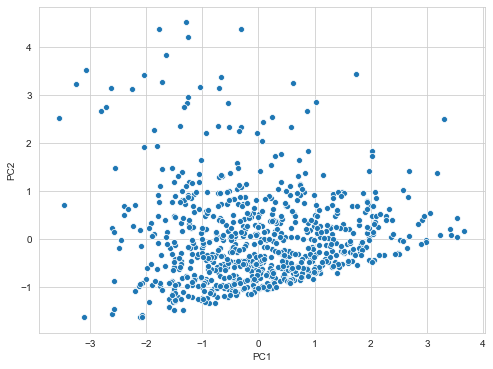

In [36]:
# Plotting the data
plt.figure(figsize = (8, 6))
sns.scatterplot(data = scaled_pca, x = 'PC1', y = 'PC2')

Text(0, 0.5, 'Inertia')

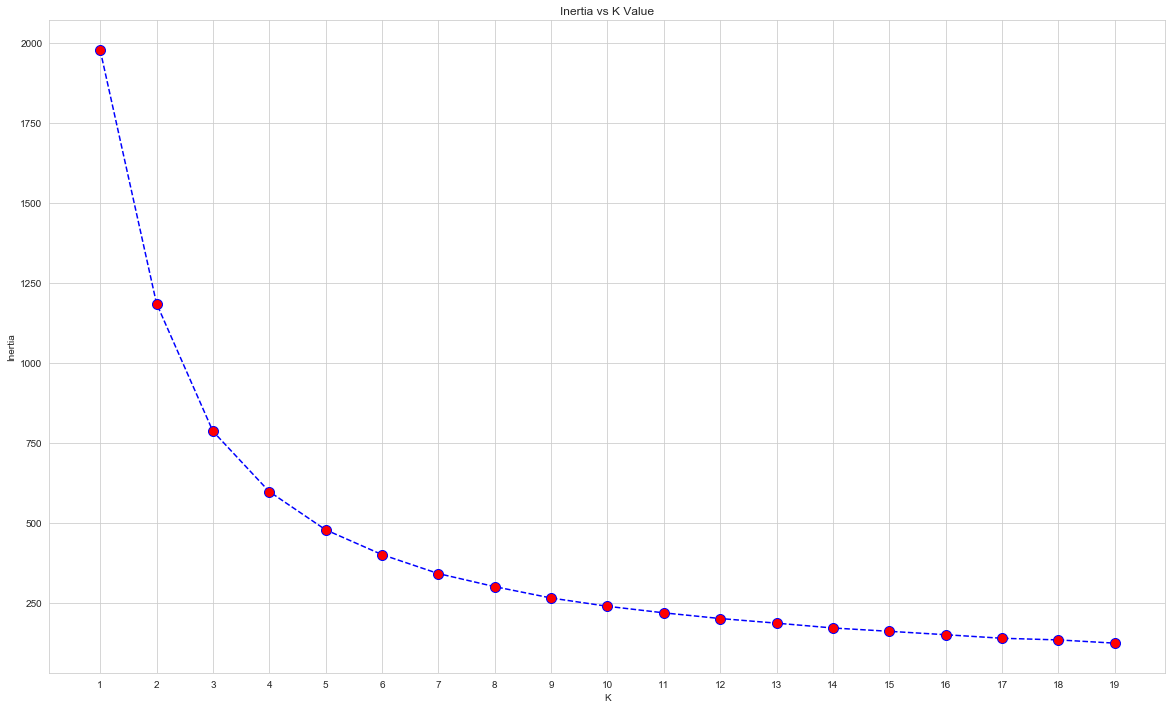

In [37]:
# Elbow method to determine number of k
inertia_list = list()

for i in range(1, 20):
    km = KMeans(n_clusters = i)
    km.fit(scaled_pca)
    inertia_list.append(km.inertia_)
    
plt.figure(figsize = (20, 12))
plt.plot(range(1, 20), inertia_list, color = 'blue', linestyle = 'dashed', 
         marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Inertia vs K Value')
plt.xticks(range(1, 20))
plt.xlabel('K')
plt.ylabel('Inertia')

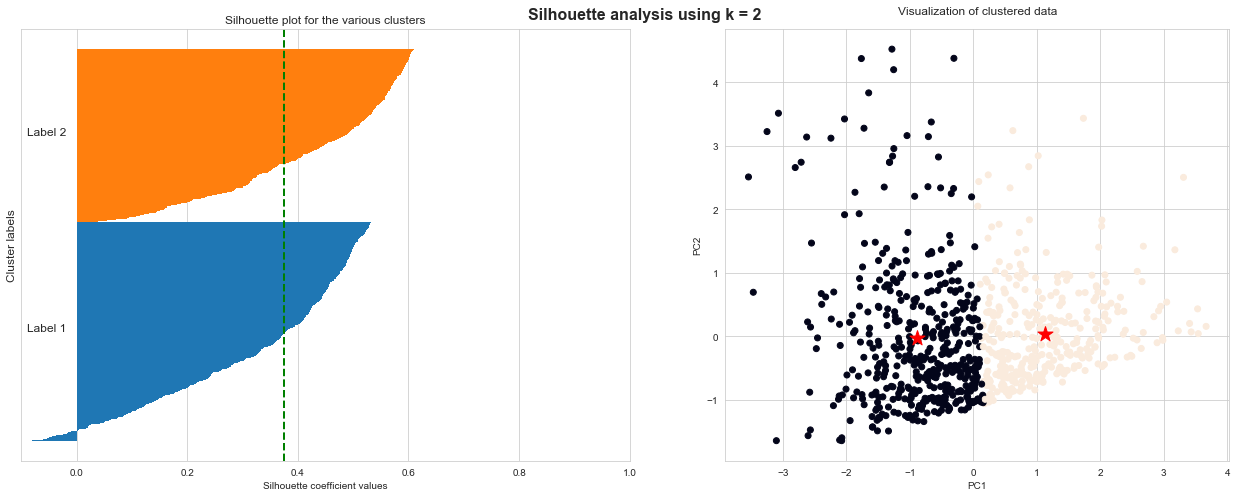

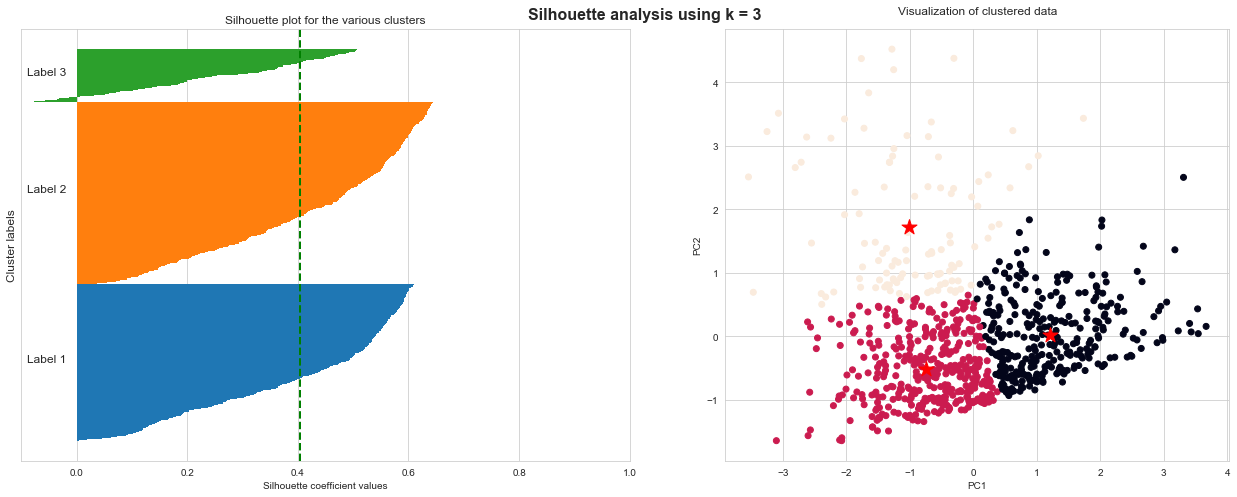

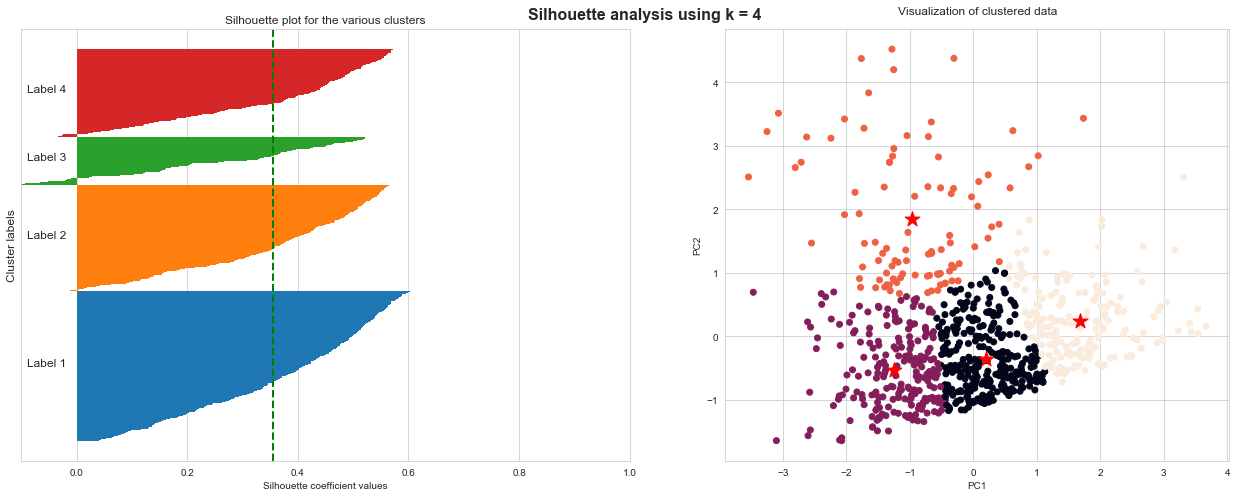

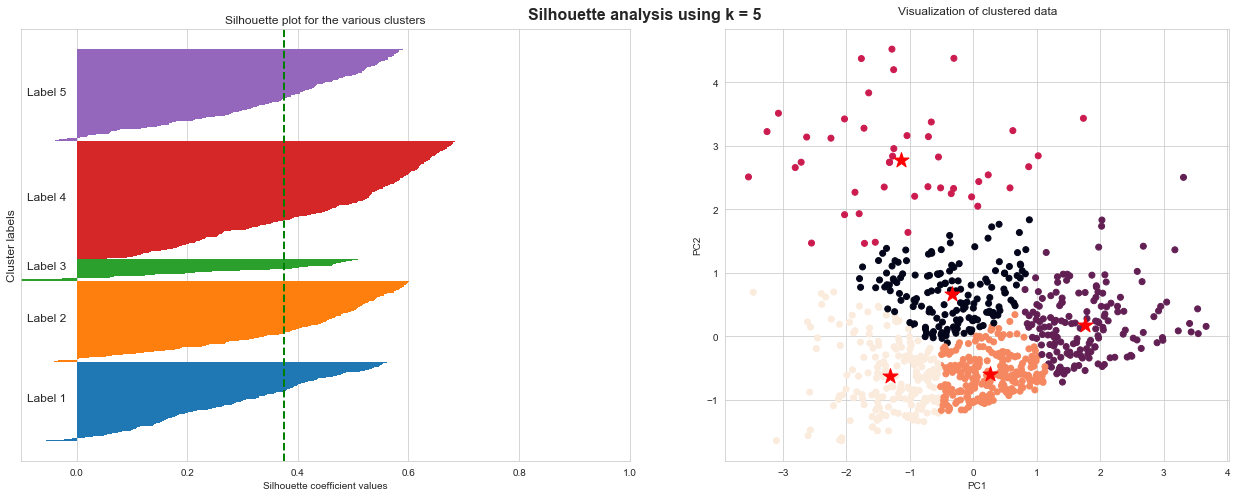

In [38]:
# Making silhouette chart
for i, k in enumerate(list(range(2,6))):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ## Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(scaled_pca)
    centroids_1 = km.cluster_centers_

    ## Get silhouette samples
    silhouette_vals = silhouette_samples(scaled_pca, labels)

    ## Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height = 1)
        ax1.text(-0.09, (y_lower + y_upper) / 2, 'Label '+str(i + 1), fontsize = 12)
        y_lower += len(cluster_silhouette_vals)

    ## Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels', fontsize = 12)
    ax1.set_title('Silhouette plot for the various clusters');
    
    ## Scatter plot of data colored with labels
    ax2.scatter(scaled_pca['PC1'], scaled_pca['PC2'], c = labels)
    ax2.scatter(centroids_1[:, 0], centroids_1[:, 1], marker = '*', c = 'r', s = 250)
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_title('Visualization of clustered data', y = 1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle('Silhouette analysis using k = {}'.format(k),
                 fontsize=16, fontweight='semibold')

### 3.2.2. DBSCAN

In [39]:
# Hyperparameter tuning for DBSCAN
score_dbscan = []

for num in range(2, 50):
    for eps in np.linspace(0.01, 1, 100):
        dbscan = DBSCAN(eps = eps, min_samples = num).fit(scaled_pca)
        labels = dbscan.labels_
        try:
            s_score = silhouette_score(scaled_pca, labels)
            print('Average Silhouette Score for eps = {} and min samples {} is {}'.format(eps, num, s_score))
            score_dbscan.append({'min_sample': num, 'epsilon': eps, 'score': s_score})
        except:
            print('eps = {} and min samples {} result in only 1 Label'.format(eps, num))

eps = 0.01 and min samples 2 result in only 1 Label
eps = 0.02 and min samples 2 result in only 1 Label
eps = 0.03 and min samples 2 result in only 1 Label
eps = 0.04 and min samples 2 result in only 1 Label
eps = 0.05 and min samples 2 result in only 1 Label
eps = 0.060000000000000005 and min samples 2 result in only 1 Label
eps = 0.06999999999999999 and min samples 2 result in only 1 Label
eps = 0.08 and min samples 2 result in only 1 Label
eps = 0.09 and min samples 2 result in only 1 Label
eps = 0.09999999999999999 and min samples 2 result in only 1 Label
eps = 0.11 and min samples 2 result in only 1 Label
eps = 0.12 and min samples 2 result in only 1 Label
eps = 0.13 and min samples 2 result in only 1 Label
eps = 0.14 and min samples 2 result in only 1 Label
eps = 0.15000000000000002 and min samples 2 result in only 1 Label
eps = 0.16 and min samples 2 result in only 1 Label
eps = 0.17 and min samples 2 result in only 1 Label
eps = 0.18000000000000002 and min samples 2 result in o

eps = 0.59 and min samples 3 result in only 1 Label
eps = 0.6 and min samples 3 result in only 1 Label
eps = 0.61 and min samples 3 result in only 1 Label
eps = 0.62 and min samples 3 result in only 1 Label
eps = 0.63 and min samples 3 result in only 1 Label
eps = 0.64 and min samples 3 result in only 1 Label
eps = 0.65 and min samples 3 result in only 1 Label
eps = 0.66 and min samples 3 result in only 1 Label
eps = 0.67 and min samples 3 result in only 1 Label
eps = 0.68 and min samples 3 result in only 1 Label
eps = 0.6900000000000001 and min samples 3 result in only 1 Label
eps = 0.7000000000000001 and min samples 3 result in only 1 Label
eps = 0.7100000000000001 and min samples 3 result in only 1 Label
eps = 0.72 and min samples 3 result in only 1 Label
eps = 0.73 and min samples 3 result in only 1 Label
eps = 0.74 and min samples 3 result in only 1 Label
eps = 0.75 and min samples 3 result in only 1 Label
eps = 0.76 and min samples 3 result in only 1 Label
eps = 0.77 and min samp

eps = 0.31 and min samples 5 result in only 1 Label
eps = 0.32 and min samples 5 result in only 1 Label
eps = 0.33 and min samples 5 result in only 1 Label
eps = 0.34 and min samples 5 result in only 1 Label
eps = 0.35000000000000003 and min samples 5 result in only 1 Label
eps = 0.36000000000000004 and min samples 5 result in only 1 Label
eps = 0.37 and min samples 5 result in only 1 Label
eps = 0.38 and min samples 5 result in only 1 Label
eps = 0.39 and min samples 5 result in only 1 Label
eps = 0.4 and min samples 5 result in only 1 Label
eps = 0.41000000000000003 and min samples 5 result in only 1 Label
eps = 0.42000000000000004 and min samples 5 result in only 1 Label
eps = 0.43 and min samples 5 result in only 1 Label
eps = 0.44 and min samples 5 result in only 1 Label
eps = 0.45 and min samples 5 result in only 1 Label
eps = 0.46 and min samples 5 result in only 1 Label
eps = 0.47000000000000003 and min samples 5 result in only 1 Label
eps = 0.48000000000000004 and min samples 

eps = 0.8300000000000001 and min samples 6 result in only 1 Label
eps = 0.8400000000000001 and min samples 6 result in only 1 Label
eps = 0.85 and min samples 6 result in only 1 Label
eps = 0.86 and min samples 6 result in only 1 Label
eps = 0.87 and min samples 6 result in only 1 Label
eps = 0.88 and min samples 6 result in only 1 Label
eps = 0.89 and min samples 6 result in only 1 Label
eps = 0.9 and min samples 6 result in only 1 Label
eps = 0.91 and min samples 6 result in only 1 Label
eps = 0.92 and min samples 6 result in only 1 Label
eps = 0.93 and min samples 6 result in only 1 Label
eps = 0.9400000000000001 and min samples 6 result in only 1 Label
eps = 0.9500000000000001 and min samples 6 result in only 1 Label
eps = 0.9600000000000001 and min samples 6 result in only 1 Label
eps = 0.97 and min samples 6 result in only 1 Label
eps = 0.98 and min samples 6 result in only 1 Label
eps = 0.99 and min samples 6 result in only 1 Label
eps = 1.0 and min samples 6 result in only 1 La

eps = 0.44 and min samples 8 result in only 1 Label
eps = 0.45 and min samples 8 result in only 1 Label
eps = 0.46 and min samples 8 result in only 1 Label
eps = 0.47000000000000003 and min samples 8 result in only 1 Label
eps = 0.48000000000000004 and min samples 8 result in only 1 Label
eps = 0.49 and min samples 8 result in only 1 Label
eps = 0.5 and min samples 8 result in only 1 Label
eps = 0.51 and min samples 8 result in only 1 Label
eps = 0.52 and min samples 8 result in only 1 Label
eps = 0.53 and min samples 8 result in only 1 Label
eps = 0.54 and min samples 8 result in only 1 Label
eps = 0.55 and min samples 8 result in only 1 Label
eps = 0.56 and min samples 8 result in only 1 Label
eps = 0.5700000000000001 and min samples 8 result in only 1 Label
eps = 0.5800000000000001 and min samples 8 result in only 1 Label
eps = 0.59 and min samples 8 result in only 1 Label
eps = 0.6 and min samples 8 result in only 1 Label
eps = 0.61 and min samples 8 result in only 1 Label
eps = 0.

eps = 0.9600000000000001 and min samples 9 result in only 1 Label
eps = 0.97 and min samples 9 result in only 1 Label
eps = 0.98 and min samples 9 result in only 1 Label
eps = 0.99 and min samples 9 result in only 1 Label
eps = 1.0 and min samples 9 result in only 1 Label
eps = 0.01 and min samples 10 result in only 1 Label
eps = 0.02 and min samples 10 result in only 1 Label
eps = 0.03 and min samples 10 result in only 1 Label
eps = 0.04 and min samples 10 result in only 1 Label
eps = 0.05 and min samples 10 result in only 1 Label
eps = 0.060000000000000005 and min samples 10 result in only 1 Label
eps = 0.06999999999999999 and min samples 10 result in only 1 Label
eps = 0.08 and min samples 10 result in only 1 Label
eps = 0.09 and min samples 10 result in only 1 Label
eps = 0.09999999999999999 and min samples 10 result in only 1 Label
eps = 0.11 and min samples 10 result in only 1 Label
eps = 0.12 and min samples 10 result in only 1 Label
eps = 0.13 and min samples 10 result in only 

eps = 0.43 and min samples 11 result in only 1 Label
eps = 0.44 and min samples 11 result in only 1 Label
eps = 0.45 and min samples 11 result in only 1 Label
eps = 0.46 and min samples 11 result in only 1 Label
eps = 0.47000000000000003 and min samples 11 result in only 1 Label
eps = 0.48000000000000004 and min samples 11 result in only 1 Label
eps = 0.49 and min samples 11 result in only 1 Label
eps = 0.5 and min samples 11 result in only 1 Label
eps = 0.51 and min samples 11 result in only 1 Label
eps = 0.52 and min samples 11 result in only 1 Label
eps = 0.53 and min samples 11 result in only 1 Label
eps = 0.54 and min samples 11 result in only 1 Label
eps = 0.55 and min samples 11 result in only 1 Label
eps = 0.56 and min samples 11 result in only 1 Label
eps = 0.5700000000000001 and min samples 11 result in only 1 Label
eps = 0.5800000000000001 and min samples 11 result in only 1 Label
eps = 0.59 and min samples 11 result in only 1 Label
eps = 0.6 and min samples 11 result in onl

eps = 0.93 and min samples 12 result in only 1 Label
eps = 0.9400000000000001 and min samples 12 result in only 1 Label
eps = 0.9500000000000001 and min samples 12 result in only 1 Label
eps = 0.9600000000000001 and min samples 12 result in only 1 Label
eps = 0.97 and min samples 12 result in only 1 Label
eps = 0.98 and min samples 12 result in only 1 Label
eps = 0.99 and min samples 12 result in only 1 Label
eps = 1.0 and min samples 12 result in only 1 Label
eps = 0.01 and min samples 13 result in only 1 Label
eps = 0.02 and min samples 13 result in only 1 Label
eps = 0.03 and min samples 13 result in only 1 Label
eps = 0.04 and min samples 13 result in only 1 Label
eps = 0.05 and min samples 13 result in only 1 Label
eps = 0.060000000000000005 and min samples 13 result in only 1 Label
eps = 0.06999999999999999 and min samples 13 result in only 1 Label
eps = 0.08 and min samples 13 result in only 1 Label
eps = 0.09 and min samples 13 result in only 1 Label
eps = 0.09999999999999999 a

eps = 0.38 and min samples 14 result in only 1 Label
eps = 0.39 and min samples 14 result in only 1 Label
eps = 0.4 and min samples 14 result in only 1 Label
eps = 0.41000000000000003 and min samples 14 result in only 1 Label
eps = 0.42000000000000004 and min samples 14 result in only 1 Label
eps = 0.43 and min samples 14 result in only 1 Label
eps = 0.44 and min samples 14 result in only 1 Label
eps = 0.45 and min samples 14 result in only 1 Label
eps = 0.46 and min samples 14 result in only 1 Label
eps = 0.47000000000000003 and min samples 14 result in only 1 Label
eps = 0.48000000000000004 and min samples 14 result in only 1 Label
eps = 0.49 and min samples 14 result in only 1 Label
eps = 0.5 and min samples 14 result in only 1 Label
eps = 0.51 and min samples 14 result in only 1 Label
eps = 0.52 and min samples 14 result in only 1 Label
eps = 0.53 and min samples 14 result in only 1 Label
eps = 0.54 and min samples 14 result in only 1 Label
eps = 0.55 and min samples 14 result in o

eps = 0.89 and min samples 15 result in only 1 Label
eps = 0.9 and min samples 15 result in only 1 Label
eps = 0.91 and min samples 15 result in only 1 Label
eps = 0.92 and min samples 15 result in only 1 Label
eps = 0.93 and min samples 15 result in only 1 Label
eps = 0.9400000000000001 and min samples 15 result in only 1 Label
eps = 0.9500000000000001 and min samples 15 result in only 1 Label
eps = 0.9600000000000001 and min samples 15 result in only 1 Label
eps = 0.97 and min samples 15 result in only 1 Label
eps = 0.98 and min samples 15 result in only 1 Label
eps = 0.99 and min samples 15 result in only 1 Label
eps = 1.0 and min samples 15 result in only 1 Label
eps = 0.01 and min samples 16 result in only 1 Label
eps = 0.02 and min samples 16 result in only 1 Label
eps = 0.03 and min samples 16 result in only 1 Label
eps = 0.04 and min samples 16 result in only 1 Label
eps = 0.05 and min samples 16 result in only 1 Label
eps = 0.060000000000000005 and min samples 16 result in onl

eps = 0.5 and min samples 17 result in only 1 Label
eps = 0.51 and min samples 17 result in only 1 Label
eps = 0.52 and min samples 17 result in only 1 Label
eps = 0.53 and min samples 17 result in only 1 Label
eps = 0.54 and min samples 17 result in only 1 Label
eps = 0.55 and min samples 17 result in only 1 Label
eps = 0.56 and min samples 17 result in only 1 Label
eps = 0.5700000000000001 and min samples 17 result in only 1 Label
eps = 0.5800000000000001 and min samples 17 result in only 1 Label
eps = 0.59 and min samples 17 result in only 1 Label
eps = 0.6 and min samples 17 result in only 1 Label
eps = 0.61 and min samples 17 result in only 1 Label
eps = 0.62 and min samples 17 result in only 1 Label
eps = 0.63 and min samples 17 result in only 1 Label
eps = 0.64 and min samples 17 result in only 1 Label
eps = 0.65 and min samples 17 result in only 1 Label
eps = 0.66 and min samples 17 result in only 1 Label
eps = 0.67 and min samples 17 result in only 1 Label
eps = 0.68 and min s

eps = 0.99 and min samples 18 result in only 1 Label
eps = 1.0 and min samples 18 result in only 1 Label
eps = 0.01 and min samples 19 result in only 1 Label
eps = 0.02 and min samples 19 result in only 1 Label
eps = 0.03 and min samples 19 result in only 1 Label
eps = 0.04 and min samples 19 result in only 1 Label
eps = 0.05 and min samples 19 result in only 1 Label
eps = 0.060000000000000005 and min samples 19 result in only 1 Label
eps = 0.06999999999999999 and min samples 19 result in only 1 Label
eps = 0.08 and min samples 19 result in only 1 Label
eps = 0.09 and min samples 19 result in only 1 Label
eps = 0.09999999999999999 and min samples 19 result in only 1 Label
eps = 0.11 and min samples 19 result in only 1 Label
eps = 0.12 and min samples 19 result in only 1 Label
eps = 0.13 and min samples 19 result in only 1 Label
eps = 0.14 and min samples 19 result in only 1 Label
eps = 0.15000000000000002 and min samples 19 result in only 1 Label
eps = 0.16 and min samples 19 result in

eps = 0.62 and min samples 20 result in only 1 Label
eps = 0.63 and min samples 20 result in only 1 Label
eps = 0.64 and min samples 20 result in only 1 Label
eps = 0.65 and min samples 20 result in only 1 Label
eps = 0.66 and min samples 20 result in only 1 Label
eps = 0.67 and min samples 20 result in only 1 Label
eps = 0.68 and min samples 20 result in only 1 Label
eps = 0.6900000000000001 and min samples 20 result in only 1 Label
eps = 0.7000000000000001 and min samples 20 result in only 1 Label
eps = 0.7100000000000001 and min samples 20 result in only 1 Label
eps = 0.72 and min samples 20 result in only 1 Label
eps = 0.73 and min samples 20 result in only 1 Label
eps = 0.74 and min samples 20 result in only 1 Label
eps = 0.75 and min samples 20 result in only 1 Label
eps = 0.76 and min samples 20 result in only 1 Label
eps = 0.77 and min samples 20 result in only 1 Label
eps = 0.78 and min samples 20 result in only 1 Label
eps = 0.79 and min samples 20 result in only 1 Label
eps 

eps = 0.17 and min samples 22 result in only 1 Label
eps = 0.18000000000000002 and min samples 22 result in only 1 Label
eps = 0.19 and min samples 22 result in only 1 Label
eps = 0.2 and min samples 22 result in only 1 Label
eps = 0.21000000000000002 and min samples 22 result in only 1 Label
eps = 0.22 and min samples 22 result in only 1 Label
eps = 0.23 and min samples 22 result in only 1 Label
eps = 0.24000000000000002 and min samples 22 result in only 1 Label
eps = 0.25 and min samples 22 result in only 1 Label
eps = 0.26 and min samples 22 result in only 1 Label
eps = 0.27 and min samples 22 result in only 1 Label
eps = 0.28 and min samples 22 result in only 1 Label
eps = 0.29000000000000004 and min samples 22 result in only 1 Label
eps = 0.3 and min samples 22 result in only 1 Label
eps = 0.31 and min samples 22 result in only 1 Label
eps = 0.32 and min samples 22 result in only 1 Label
eps = 0.33 and min samples 22 result in only 1 Label
eps = 0.34 and min samples 22 result in o

eps = 0.76 and min samples 23 result in only 1 Label
eps = 0.77 and min samples 23 result in only 1 Label
eps = 0.78 and min samples 23 result in only 1 Label
eps = 0.79 and min samples 23 result in only 1 Label
eps = 0.8 and min samples 23 result in only 1 Label
eps = 0.81 and min samples 23 result in only 1 Label
eps = 0.8200000000000001 and min samples 23 result in only 1 Label
eps = 0.8300000000000001 and min samples 23 result in only 1 Label
eps = 0.8400000000000001 and min samples 23 result in only 1 Label
eps = 0.85 and min samples 23 result in only 1 Label
eps = 0.86 and min samples 23 result in only 1 Label
eps = 0.87 and min samples 23 result in only 1 Label
eps = 0.88 and min samples 23 result in only 1 Label
eps = 0.89 and min samples 23 result in only 1 Label
eps = 0.9 and min samples 23 result in only 1 Label
eps = 0.91 and min samples 23 result in only 1 Label
eps = 0.92 and min samples 23 result in only 1 Label
eps = 0.93 and min samples 23 result in only 1 Label
eps = 

eps = 0.32 and min samples 25 result in only 1 Label
eps = 0.33 and min samples 25 result in only 1 Label
eps = 0.34 and min samples 25 result in only 1 Label
eps = 0.35000000000000003 and min samples 25 result in only 1 Label
eps = 0.36000000000000004 and min samples 25 result in only 1 Label
eps = 0.37 and min samples 25 result in only 1 Label
eps = 0.38 and min samples 25 result in only 1 Label
eps = 0.39 and min samples 25 result in only 1 Label
eps = 0.4 and min samples 25 result in only 1 Label
eps = 0.41000000000000003 and min samples 25 result in only 1 Label
eps = 0.42000000000000004 and min samples 25 result in only 1 Label
eps = 0.43 and min samples 25 result in only 1 Label
eps = 0.44 and min samples 25 result in only 1 Label
eps = 0.45 and min samples 25 result in only 1 Label
eps = 0.46 and min samples 25 result in only 1 Label
eps = 0.47000000000000003 and min samples 25 result in only 1 Label
eps = 0.48000000000000004 and min samples 25 result in only 1 Label
eps = 0.49

eps = 0.89 and min samples 26 result in only 1 Label
eps = 0.9 and min samples 26 result in only 1 Label
eps = 0.91 and min samples 26 result in only 1 Label
eps = 0.92 and min samples 26 result in only 1 Label
eps = 0.93 and min samples 26 result in only 1 Label
eps = 0.9400000000000001 and min samples 26 result in only 1 Label
eps = 0.9500000000000001 and min samples 26 result in only 1 Label
eps = 0.9600000000000001 and min samples 26 result in only 1 Label
eps = 0.97 and min samples 26 result in only 1 Label
eps = 0.98 and min samples 26 result in only 1 Label
eps = 0.99 and min samples 26 result in only 1 Label
eps = 1.0 and min samples 26 result in only 1 Label
eps = 0.01 and min samples 27 result in only 1 Label
eps = 0.02 and min samples 27 result in only 1 Label
eps = 0.03 and min samples 27 result in only 1 Label
eps = 0.04 and min samples 27 result in only 1 Label
eps = 0.05 and min samples 27 result in only 1 Label
eps = 0.060000000000000005 and min samples 27 result in onl

eps = 0.45 and min samples 28 result in only 1 Label
eps = 0.46 and min samples 28 result in only 1 Label
eps = 0.47000000000000003 and min samples 28 result in only 1 Label
eps = 0.48000000000000004 and min samples 28 result in only 1 Label
eps = 0.49 and min samples 28 result in only 1 Label
eps = 0.5 and min samples 28 result in only 1 Label
eps = 0.51 and min samples 28 result in only 1 Label
eps = 0.52 and min samples 28 result in only 1 Label
eps = 0.53 and min samples 28 result in only 1 Label
eps = 0.54 and min samples 28 result in only 1 Label
eps = 0.55 and min samples 28 result in only 1 Label
eps = 0.56 and min samples 28 result in only 1 Label
eps = 0.5700000000000001 and min samples 28 result in only 1 Label
eps = 0.5800000000000001 and min samples 28 result in only 1 Label
eps = 0.59 and min samples 28 result in only 1 Label
eps = 0.6 and min samples 28 result in only 1 Label
eps = 0.61 and min samples 28 result in only 1 Label
eps = 0.62 and min samples 28 result in onl

eps = 0.9400000000000001 and min samples 29 result in only 1 Label
eps = 0.9500000000000001 and min samples 29 result in only 1 Label
eps = 0.9600000000000001 and min samples 29 result in only 1 Label
eps = 0.97 and min samples 29 result in only 1 Label
eps = 0.98 and min samples 29 result in only 1 Label
eps = 0.99 and min samples 29 result in only 1 Label
eps = 1.0 and min samples 29 result in only 1 Label
eps = 0.01 and min samples 30 result in only 1 Label
eps = 0.02 and min samples 30 result in only 1 Label
eps = 0.03 and min samples 30 result in only 1 Label
eps = 0.04 and min samples 30 result in only 1 Label
eps = 0.05 and min samples 30 result in only 1 Label
eps = 0.060000000000000005 and min samples 30 result in only 1 Label
eps = 0.06999999999999999 and min samples 30 result in only 1 Label
eps = 0.08 and min samples 30 result in only 1 Label
eps = 0.09 and min samples 30 result in only 1 Label
eps = 0.09999999999999999 and min samples 30 result in only 1 Label
eps = 0.11 a

eps = 0.56 and min samples 31 result in only 1 Label
eps = 0.5700000000000001 and min samples 31 result in only 1 Label
eps = 0.5800000000000001 and min samples 31 result in only 1 Label
eps = 0.59 and min samples 31 result in only 1 Label
eps = 0.6 and min samples 31 result in only 1 Label
eps = 0.61 and min samples 31 result in only 1 Label
eps = 0.62 and min samples 31 result in only 1 Label
eps = 0.63 and min samples 31 result in only 1 Label
eps = 0.64 and min samples 31 result in only 1 Label
eps = 0.65 and min samples 31 result in only 1 Label
eps = 0.66 and min samples 31 result in only 1 Label
eps = 0.67 and min samples 31 result in only 1 Label
eps = 0.68 and min samples 31 result in only 1 Label
eps = 0.6900000000000001 and min samples 31 result in only 1 Label
eps = 0.7000000000000001 and min samples 31 result in only 1 Label
eps = 0.7100000000000001 and min samples 31 result in only 1 Label
eps = 0.72 and min samples 31 result in only 1 Label
eps = 0.73 and min samples 31 

eps = 0.29000000000000004 and min samples 33 result in only 1 Label
eps = 0.3 and min samples 33 result in only 1 Label
eps = 0.31 and min samples 33 result in only 1 Label
eps = 0.32 and min samples 33 result in only 1 Label
eps = 0.33 and min samples 33 result in only 1 Label
eps = 0.34 and min samples 33 result in only 1 Label
eps = 0.35000000000000003 and min samples 33 result in only 1 Label
eps = 0.36000000000000004 and min samples 33 result in only 1 Label
eps = 0.37 and min samples 33 result in only 1 Label
eps = 0.38 and min samples 33 result in only 1 Label
eps = 0.39 and min samples 33 result in only 1 Label
eps = 0.4 and min samples 33 result in only 1 Label
eps = 0.41000000000000003 and min samples 33 result in only 1 Label
eps = 0.42000000000000004 and min samples 33 result in only 1 Label
eps = 0.43 and min samples 33 result in only 1 Label
eps = 0.44 and min samples 33 result in only 1 Label
eps = 0.45 and min samples 33 result in only 1 Label
eps = 0.46 and min samples

eps = 0.77 and min samples 34 result in only 1 Label
eps = 0.78 and min samples 34 result in only 1 Label
eps = 0.79 and min samples 34 result in only 1 Label
eps = 0.8 and min samples 34 result in only 1 Label
eps = 0.81 and min samples 34 result in only 1 Label
eps = 0.8200000000000001 and min samples 34 result in only 1 Label
eps = 0.8300000000000001 and min samples 34 result in only 1 Label
eps = 0.8400000000000001 and min samples 34 result in only 1 Label
eps = 0.85 and min samples 34 result in only 1 Label
eps = 0.86 and min samples 34 result in only 1 Label
eps = 0.87 and min samples 34 result in only 1 Label
eps = 0.88 and min samples 34 result in only 1 Label
eps = 0.89 and min samples 34 result in only 1 Label
eps = 0.9 and min samples 34 result in only 1 Label
eps = 0.91 and min samples 34 result in only 1 Label
eps = 0.92 and min samples 34 result in only 1 Label
eps = 0.93 and min samples 34 result in only 1 Label
eps = 0.9400000000000001 and min samples 34 result in only 

eps = 0.41000000000000003 and min samples 36 result in only 1 Label
eps = 0.42000000000000004 and min samples 36 result in only 1 Label
eps = 0.43 and min samples 36 result in only 1 Label
eps = 0.44 and min samples 36 result in only 1 Label
eps = 0.45 and min samples 36 result in only 1 Label
eps = 0.46 and min samples 36 result in only 1 Label
eps = 0.47000000000000003 and min samples 36 result in only 1 Label
eps = 0.48000000000000004 and min samples 36 result in only 1 Label
eps = 0.49 and min samples 36 result in only 1 Label
eps = 0.5 and min samples 36 result in only 1 Label
eps = 0.51 and min samples 36 result in only 1 Label
eps = 0.52 and min samples 36 result in only 1 Label
eps = 0.53 and min samples 36 result in only 1 Label
eps = 0.54 and min samples 36 result in only 1 Label
eps = 0.55 and min samples 36 result in only 1 Label
eps = 0.56 and min samples 36 result in only 1 Label
eps = 0.5700000000000001 and min samples 36 result in only 1 Label
eps = 0.5800000000000001 a

eps = 0.93 and min samples 37 result in only 1 Label
eps = 0.9400000000000001 and min samples 37 result in only 1 Label
eps = 0.9500000000000001 and min samples 37 result in only 1 Label
eps = 0.9600000000000001 and min samples 37 result in only 1 Label
eps = 0.97 and min samples 37 result in only 1 Label
eps = 0.98 and min samples 37 result in only 1 Label
eps = 0.99 and min samples 37 result in only 1 Label
eps = 1.0 and min samples 37 result in only 1 Label
eps = 0.01 and min samples 38 result in only 1 Label
eps = 0.02 and min samples 38 result in only 1 Label
eps = 0.03 and min samples 38 result in only 1 Label
eps = 0.04 and min samples 38 result in only 1 Label
eps = 0.05 and min samples 38 result in only 1 Label
eps = 0.060000000000000005 and min samples 38 result in only 1 Label
eps = 0.06999999999999999 and min samples 38 result in only 1 Label
eps = 0.08 and min samples 38 result in only 1 Label
eps = 0.09 and min samples 38 result in only 1 Label
eps = 0.09999999999999999 a

eps = 0.44 and min samples 39 result in only 1 Label
eps = 0.45 and min samples 39 result in only 1 Label
eps = 0.46 and min samples 39 result in only 1 Label
eps = 0.47000000000000003 and min samples 39 result in only 1 Label
eps = 0.48000000000000004 and min samples 39 result in only 1 Label
eps = 0.49 and min samples 39 result in only 1 Label
eps = 0.5 and min samples 39 result in only 1 Label
eps = 0.51 and min samples 39 result in only 1 Label
eps = 0.52 and min samples 39 result in only 1 Label
eps = 0.53 and min samples 39 result in only 1 Label
eps = 0.54 and min samples 39 result in only 1 Label
eps = 0.55 and min samples 39 result in only 1 Label
eps = 0.56 and min samples 39 result in only 1 Label
eps = 0.5700000000000001 and min samples 39 result in only 1 Label
eps = 0.5800000000000001 and min samples 39 result in only 1 Label
eps = 0.59 and min samples 39 result in only 1 Label
eps = 0.6 and min samples 39 result in only 1 Label
eps = 0.61 and min samples 39 result in onl

eps = 0.9500000000000001 and min samples 40 result in only 1 Label
eps = 0.9600000000000001 and min samples 40 result in only 1 Label
eps = 0.97 and min samples 40 result in only 1 Label
eps = 0.98 and min samples 40 result in only 1 Label
eps = 0.99 and min samples 40 result in only 1 Label
eps = 1.0 and min samples 40 result in only 1 Label
eps = 0.01 and min samples 41 result in only 1 Label
eps = 0.02 and min samples 41 result in only 1 Label
eps = 0.03 and min samples 41 result in only 1 Label
eps = 0.04 and min samples 41 result in only 1 Label
eps = 0.05 and min samples 41 result in only 1 Label
eps = 0.060000000000000005 and min samples 41 result in only 1 Label
eps = 0.06999999999999999 and min samples 41 result in only 1 Label
eps = 0.08 and min samples 41 result in only 1 Label
eps = 0.09 and min samples 41 result in only 1 Label
eps = 0.09999999999999999 and min samples 41 result in only 1 Label
eps = 0.11 and min samples 41 result in only 1 Label
eps = 0.12 and min samples

eps = 0.45 and min samples 42 result in only 1 Label
eps = 0.46 and min samples 42 result in only 1 Label
eps = 0.47000000000000003 and min samples 42 result in only 1 Label
eps = 0.48000000000000004 and min samples 42 result in only 1 Label
eps = 0.49 and min samples 42 result in only 1 Label
eps = 0.5 and min samples 42 result in only 1 Label
eps = 0.51 and min samples 42 result in only 1 Label
eps = 0.52 and min samples 42 result in only 1 Label
eps = 0.53 and min samples 42 result in only 1 Label
eps = 0.54 and min samples 42 result in only 1 Label
eps = 0.55 and min samples 42 result in only 1 Label
eps = 0.56 and min samples 42 result in only 1 Label
eps = 0.5700000000000001 and min samples 42 result in only 1 Label
eps = 0.5800000000000001 and min samples 42 result in only 1 Label
eps = 0.59 and min samples 42 result in only 1 Label
eps = 0.6 and min samples 42 result in only 1 Label
eps = 0.61 and min samples 42 result in only 1 Label
eps = 0.62 and min samples 42 result in onl

eps = 0.98 and min samples 43 result in only 1 Label
eps = 0.99 and min samples 43 result in only 1 Label
eps = 1.0 and min samples 43 result in only 1 Label
eps = 0.01 and min samples 44 result in only 1 Label
eps = 0.02 and min samples 44 result in only 1 Label
eps = 0.03 and min samples 44 result in only 1 Label
eps = 0.04 and min samples 44 result in only 1 Label
eps = 0.05 and min samples 44 result in only 1 Label
eps = 0.060000000000000005 and min samples 44 result in only 1 Label
eps = 0.06999999999999999 and min samples 44 result in only 1 Label
eps = 0.08 and min samples 44 result in only 1 Label
eps = 0.09 and min samples 44 result in only 1 Label
eps = 0.09999999999999999 and min samples 44 result in only 1 Label
eps = 0.11 and min samples 44 result in only 1 Label
eps = 0.12 and min samples 44 result in only 1 Label
eps = 0.13 and min samples 44 result in only 1 Label
eps = 0.14 and min samples 44 result in only 1 Label
eps = 0.15000000000000002 and min samples 44 result in

eps = 0.59 and min samples 45 result in only 1 Label
eps = 0.6 and min samples 45 result in only 1 Label
eps = 0.61 and min samples 45 result in only 1 Label
eps = 0.62 and min samples 45 result in only 1 Label
eps = 0.63 and min samples 45 result in only 1 Label
eps = 0.64 and min samples 45 result in only 1 Label
eps = 0.65 and min samples 45 result in only 1 Label
eps = 0.66 and min samples 45 result in only 1 Label
eps = 0.67 and min samples 45 result in only 1 Label
eps = 0.68 and min samples 45 result in only 1 Label
eps = 0.6900000000000001 and min samples 45 result in only 1 Label
eps = 0.7000000000000001 and min samples 45 result in only 1 Label
eps = 0.7100000000000001 and min samples 45 result in only 1 Label
eps = 0.72 and min samples 45 result in only 1 Label
eps = 0.73 and min samples 45 result in only 1 Label
eps = 0.74 and min samples 45 result in only 1 Label
eps = 0.75 and min samples 45 result in only 1 Label
eps = 0.76 and min samples 45 result in only 1 Label
eps =

eps = 0.29000000000000004 and min samples 47 result in only 1 Label
eps = 0.3 and min samples 47 result in only 1 Label
eps = 0.31 and min samples 47 result in only 1 Label
eps = 0.32 and min samples 47 result in only 1 Label
eps = 0.33 and min samples 47 result in only 1 Label
eps = 0.34 and min samples 47 result in only 1 Label
eps = 0.35000000000000003 and min samples 47 result in only 1 Label
eps = 0.36000000000000004 and min samples 47 result in only 1 Label
eps = 0.37 and min samples 47 result in only 1 Label
eps = 0.38 and min samples 47 result in only 1 Label
eps = 0.39 and min samples 47 result in only 1 Label
eps = 0.4 and min samples 47 result in only 1 Label
eps = 0.41000000000000003 and min samples 47 result in only 1 Label
eps = 0.42000000000000004 and min samples 47 result in only 1 Label
eps = 0.43 and min samples 47 result in only 1 Label
eps = 0.44 and min samples 47 result in only 1 Label
eps = 0.45 and min samples 47 result in only 1 Label
eps = 0.46 and min samples

eps = 0.86 and min samples 48 result in only 1 Label
eps = 0.87 and min samples 48 result in only 1 Label
eps = 0.88 and min samples 48 result in only 1 Label
eps = 0.89 and min samples 48 result in only 1 Label
eps = 0.9 and min samples 48 result in only 1 Label
eps = 0.91 and min samples 48 result in only 1 Label
eps = 0.92 and min samples 48 result in only 1 Label
eps = 0.93 and min samples 48 result in only 1 Label
eps = 0.9400000000000001 and min samples 48 result in only 1 Label
eps = 0.9500000000000001 and min samples 48 result in only 1 Label
eps = 0.9600000000000001 and min samples 48 result in only 1 Label
eps = 0.97 and min samples 48 result in only 1 Label
eps = 0.98 and min samples 48 result in only 1 Label
eps = 0.99 and min samples 48 result in only 1 Label
eps = 1.0 and min samples 48 result in only 1 Label
eps = 0.01 and min samples 49 result in only 1 Label
eps = 0.02 and min samples 49 result in only 1 Label
eps = 0.03 and min samples 49 result in only 1 Label
eps = 

### 3.2.3. HDBSCAN

In [40]:
# Hyperparameter tuning for HDBSCAN
score_hdbscan = []

for c_size in range(3, 10):
    for sample in range(1, 10):
        hdbscan = HDBSCAN(min_cluster_size = c_size, min_samples = sample, gen_min_span_tree = True)
        hdbscan.fit(scaled_pca)
        ## Number of clusters in labels, ignoring noise if present
        n_clusters = len(set(hdbscan.labels_)) - (1 if -1 in hdbscan.labels_ else 0)
        n_noise = list(hdbscan.labels_).count(-1)
        print(f'Banyak cluster = {n_clusters} dan banyak noise = {n_noise} untuk min_cluster_size = {c_size} dan min_samples = {sample}')
        score_hdbscan.append({'cluster' : n_clusters, 'noise' : n_noise, 'min_cluster_size' : c_size, 'min_sample' : num})

Banyak cluster = 133 dan banyak noise = 113 untuk min_cluster_size = 3 dan min_samples = 1
Banyak cluster = 106 dan banyak noise = 200 untuk min_cluster_size = 3 dan min_samples = 2
Banyak cluster = 68 dan banyak noise = 309 untuk min_cluster_size = 3 dan min_samples = 3
Banyak cluster = 44 dan banyak noise = 402 untuk min_cluster_size = 3 dan min_samples = 4
Banyak cluster = 3 dan banyak noise = 56 untuk min_cluster_size = 3 dan min_samples = 5
Banyak cluster = 4 dan banyak noise = 50 untuk min_cluster_size = 3 dan min_samples = 6
Banyak cluster = 2 dan banyak noise = 129 untuk min_cluster_size = 3 dan min_samples = 7
Banyak cluster = 2 dan banyak noise = 38 untuk min_cluster_size = 3 dan min_samples = 8
Banyak cluster = 4 dan banyak noise = 258 untuk min_cluster_size = 3 dan min_samples = 9
Banyak cluster = 90 dan banyak noise = 149 untuk min_cluster_size = 4 dan min_samples = 1
Banyak cluster = 73 dan banyak noise = 227 untuk min_cluster_size = 4 dan min_samples = 2
Banyak cluster =

Comparison between clustering methods (PCA):
- K Means<br>
Looking at elbow chart and silhouette index, it seems that the optimal cluster is 3.
- DBSCAN<br>
I try several combinations for epsilon and minimum samples however this method always results in only 1 label.
- HDBSCAN<br>
Using this method, looking at number of noise datas, it seems that the optimal amount of cluster is 3.

In [41]:
# Generating label for datas between PCA and non-PCA
km = KMeans(n_clusters = 3)
# Non-PCA
labels_non_pca = km.fit_predict(df_rfm_new[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])
labels_non_pca += 1

# PCA
labels_pca = km.fit_predict(scaled_pca)
labels_pca += 1

In [42]:
# Concatenating original data with labels
df_final = pd.concat([df_rfm_new, 
                      pd.DataFrame(labels_non_pca, index = df_rfm_new.index, columns = ['Cluster_Non_PCA']),
                     pd.DataFrame(labels_pca, index = df_rfm_new.index, columns = ['Cluster_PCA'])], 
                     axis = 1)
df_final.head()

,Customer Name,Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale,Cluster_Non_PCA,Cluster_PCA
0,Aaron Bergman,17,37,24644.65,0.291554,0.849921,1.678322,2,2
1,Aaron Hawkins,13,34,20759.52,0.470798,0.292226,0.930059,2,2
2,Aaron Smayling,24,31,14212.62,-0.022123,-0.265468,-0.330850,1,1
3,Adam Bellavance,36,41,20186.79,-0.559854,1.593514,0.819754,2,2
4,Adam Hart,3,42,21718.24,0.918908,1.779412,1.114706,2,2


In [43]:
# Result of both clustering methods
print(df_final['Cluster_Non_PCA'].value_counts(sort = False))
print('\n')
print(df_final['Cluster_PCA'].value_counts(sort = False))

1    365
2    317
3    110
Name: Cluster_Non_PCA, dtype: int64


1    368
2    317
3    107
Name: Cluster_PCA, dtype: int64


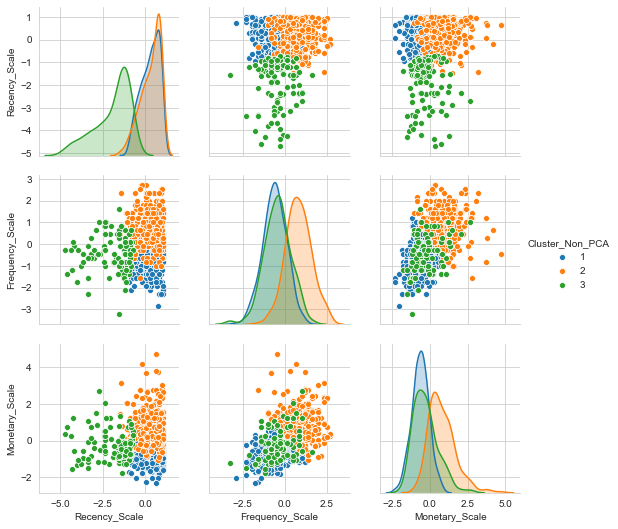

In [44]:
# Plotting data clusters based on non-PCA method
sns.pairplot(data = df_final, hue = 'Cluster_Non_PCA', vars = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'])

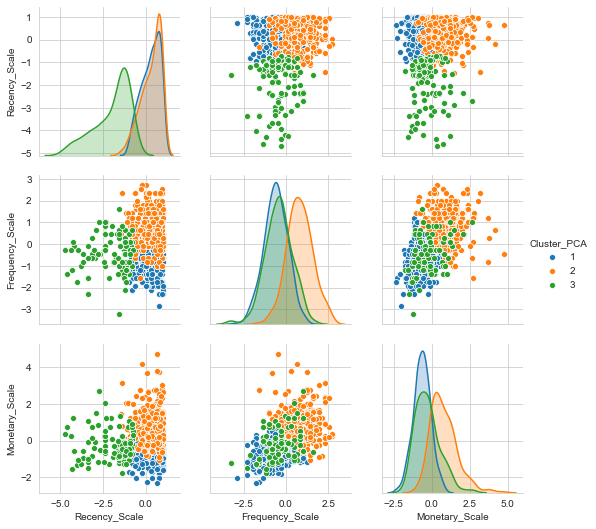

In [45]:
# Plotting data clusters based on PCA method
sns.pairplot(data = df_final, hue = 'Cluster_PCA', vars = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'])

It seems that there was no significant difference on results between non-PCA and PCA clustering method. However, since PCA method results in higher silhouette index, I will use this result.

Looking at pairplot above (PCA), I concluded that:
- First Cluster (2) belongs to our best customers which have low recency, high frequency, and high monetary
- Second Cluster (1) belongs to our loyal customers which have low recency, low frequency, and low monetary
- Third Cluster (3) belongs to potential customers which have high recency

# 4. Model Deployment

In [46]:
# Dropping names
df_cluster = df_rfm.drop(index = [571, 642, 699])

In [47]:
# Fitting StandardScaler model for pipeline
scaler_model = StandardScaler()
scaler_model.fit(df_cluster.drop(['Customer Name', 'Recency'], axis = 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [48]:
scaled_data = scaler_model.fit_transform(df_cluster.drop(['Customer Name', 'Recency'], axis = 1))
df_cluster = pd.concat([df_cluster, pd.DataFrame(scaled_data, index = df_cluster.index, 
                    columns = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'])], axis = 1)

df_cluster.head()

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale
0,Aaron Bergman,17,1445,37,24644.65,0.291554,0.849921,1.678322
1,Aaron Hawkins,13,1449,34,20759.52,0.470798,0.292226,0.930059
2,Aaron Smayling,24,1438,31,14212.62,-0.022123,-0.265468,-0.330850
3,Adam Bellavance,36,1426,41,20186.79,-0.559854,1.593514,0.819754
4,Adam Hart,3,1459,42,21718.24,0.918908,1.779412,1.114706


In [49]:
# Fitting PCA model for pipeline
pca_model = PCA(n_components = 2)
pca_model.fit(df_cluster[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [50]:
x_pca = pca_model.transform(df_cluster[['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']])
scaled_pca = pd.DataFrame(x_pca, index = df_cluster.index, columns = ['PC1', 'PC2'])
scaled_pca.head()

,PC1,PC2
0,1.790245,0.279731
1,0.958071,-0.166236
2,-0.409873,-0.103127
3,1.480692,0.978402
4,2.228552,-0.330263


In [51]:
# Fitting KMeans model for pipeline
km_model = KMeans(n_clusters = 3)
km_model.fit(scaled_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
labels = km_model.predict(scaled_pca)
labels += 1

In [53]:
df_cluster = pd.concat([df_cluster, pd.DataFrame(labels, columns = ['Cluster'], index = df_cluster.index)], axis = 1)
df_cluster.head()

,Customer Name,Recency,Inverse_Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale,Cluster
0,Aaron Bergman,17,1445,37,24644.65,0.291554,0.849921,1.678322,1
1,Aaron Hawkins,13,1449,34,20759.52,0.470798,0.292226,0.930059,1
2,Aaron Smayling,24,1438,31,14212.62,-0.022123,-0.265468,-0.330850,2
3,Adam Bellavance,36,1426,41,20186.79,-0.559854,1.593514,0.819754,1
4,Adam Hart,3,1459,42,21718.24,0.918908,1.779412,1.114706,1


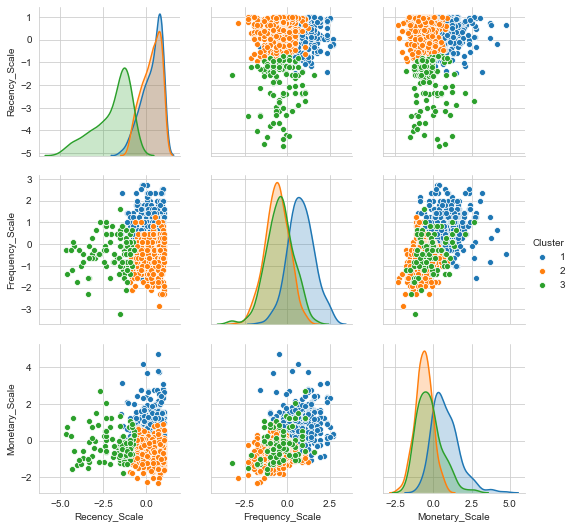

In [54]:
# Plotting data clusters
sns.pairplot(data = df_cluster, hue = 'Cluster', vars = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'])

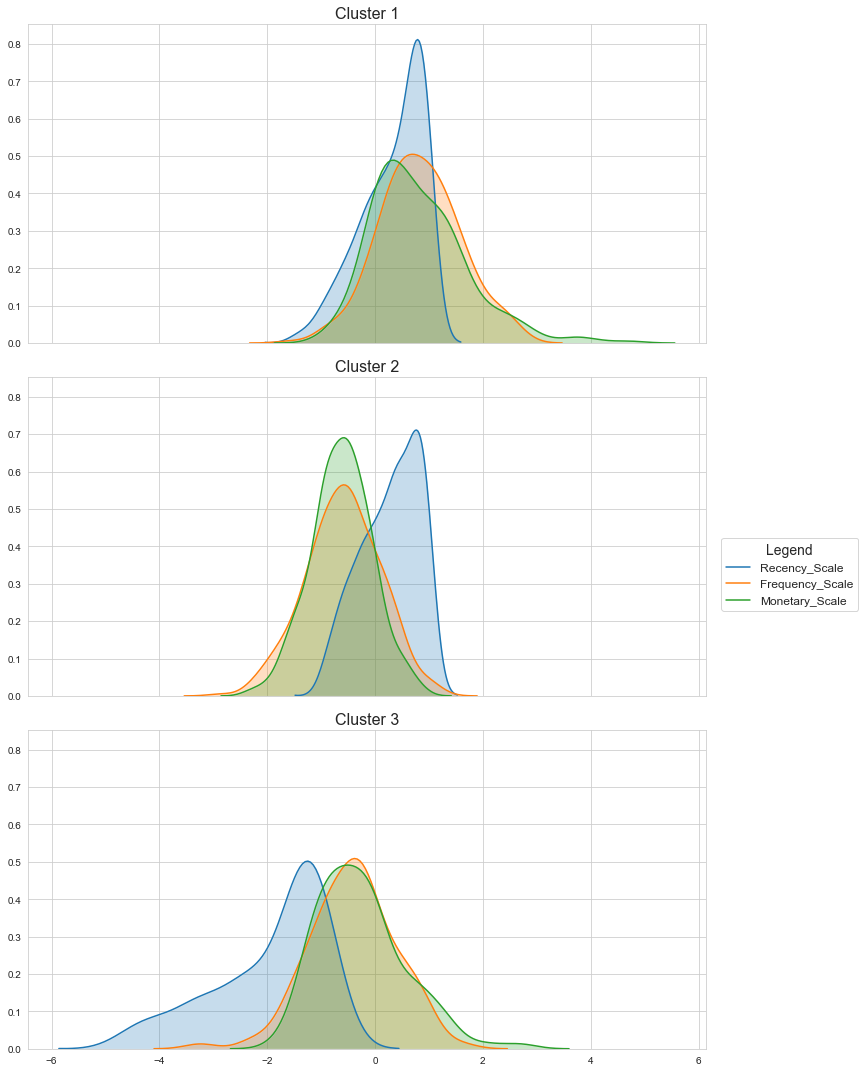

In [55]:
# Making KDE plot for each cluster
fig, ax = plt.subplots(3, 1, figsize = (10, 15), sharex = True, sharey = True)

for i in range(1, 4):
    for j in ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale']:
        sns.kdeplot(data = df_cluster[df_cluster['Cluster'] == i][j], shade = True, legend = False, ax = ax[i - 1])
        ax[i - 1].set_title(f'Cluster {i}', fontsize = 16)
fig.legend(labels = ['Recency_Scale', 'Frequency_Scale', 'Monetary_Scale'], bbox_to_anchor = (1.2, 0.5),
           fontsize = 'large', title = 'Legend', title_fontsize = 14)
plt.tight_layout()

In [56]:
# Making pipeline
from sklearn.pipeline import Pipeline
cluster_model = Pipeline([('scaler', scaler_model),
                          ('pca', pca_model),
                          ('km', km_model)])

In [57]:
# Deploying model
import pickle
pickle.dump(cluster_model, open('rfm_cluster.sav', 'wb'))

# 5. Exporting Data

In [58]:
# Exporting data
df_rfm.to_csv('datasets/superstore_rfm.csv', index = False)
df_cluster.to_csv('datasets/superstore_cluster.csv', index = False)